# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

#### Предпросмотр данных.
Открываем предоставленный файл и выводим информацию о датафрейме.

In [1]:
import pandas as pd

In [2]:
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except FileNotFoundError:
    print('Файл с данными не найден!')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В полученных данных мы наблюдаем пропуски в значениях датафрейма и неоптимальные типы данных в столбцах.

Столбцы is_apartment, balcony, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest имеют большое колличество пропусков и связано скорее всего с тем что пользователь при создании объявления не указал эти данные из-за отсутствия этих элементов или по иным причинам. Эти столбцы стоит заполнить нулевыми значениями. Стоит дополнительно проверить пропуски в столбцах parks_nearest и ponds_nearest, т.к. они связаны со столбцами parks_around3000 и ponds_around3000 в которых указанно колличество соответствующих элементов по близости и если есть пропуск в столбце nearest, то необходимо проверить значение в столбце around3000 и если это значение не нулевое, то необходимо подобрать значение для столбца nearest.

В столбцах airports_nearest, cityCenters_nearest пропуски необходимо обработать соответствующими средними значениями для поселка в котором расположена квартира из столбца locality_name.

В столбце ceiling_height пропуски можно заполнить либо стадартыми значиниями в диапазоне 2.5-2.7 по стандарту СНиП 31-01-2003, либо медианными значениями для квартир с похожей общей площадью, либо выбиваюшимся значением, которое в дальнейшем не будет включаться в условие для изучения зависимости, например 0.

Столбец floors_total можно заполнить текущим значением из floor, но в дальнейшем мы будем рассчитывать зависимости по первому/последнему этажу и все пропуски пойдут в последний этаж и исказаят данные. Соответственно лучше заполнить либо медианным значением по столбцу floors_total, либо выбиваюшимся значением, которое в дальнейшем не будет включаться в условие для изучения зависимости, например -1.

В столбцах living_area и kitchen_area пропуски нужно обработать в пропорции к отношению средней общей площали к плозади кухни или жилой плозади.

В столбце locality_name пропуски нет возможности заполнить достоверно, но можно проверить на совпадение объектов по близости от квартиры не более чем 2,5 км от похожих строк в выборке, либо заполнить пропуск значением "Не заданно", т.к. колличество пропусков не значительное.

В столбце days_exposition для определения зависимости в пропусках следует проверить значение в столбце first_day_exposition, возможно пропуск появился из-за того что текущий датафрейм был создан в день опубликования объявления клиентом.

#### Построение гистграмм
Построим гистограммы для анализа распределения значений в каждом столбце

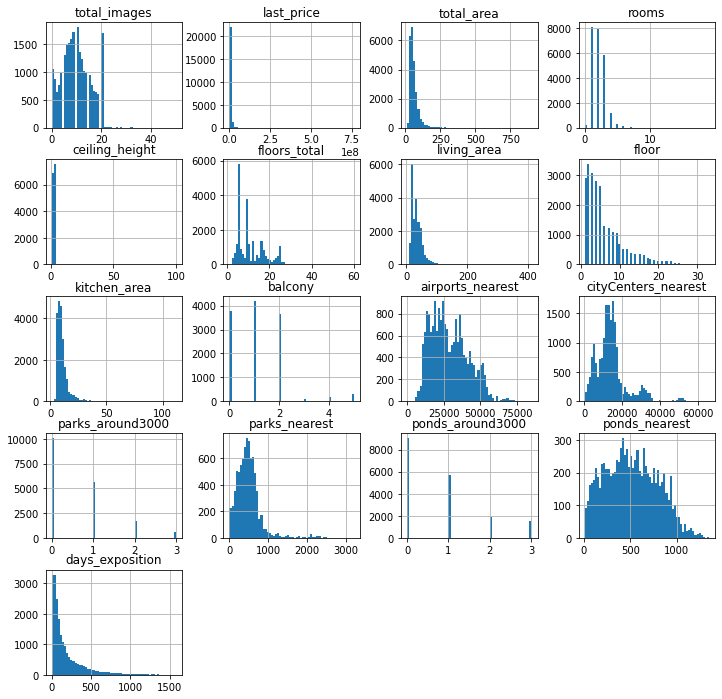

In [3]:
data.hist(bins=60, figsize=(12, 12));

На гистограммах total_images, last_price, total_area, rooms, ceiling_height, floors_total, living_area, kitchen_area явно присутствуют аномалии в данных, следует проверить их на достоверность

### Предобработка данных

In [4]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

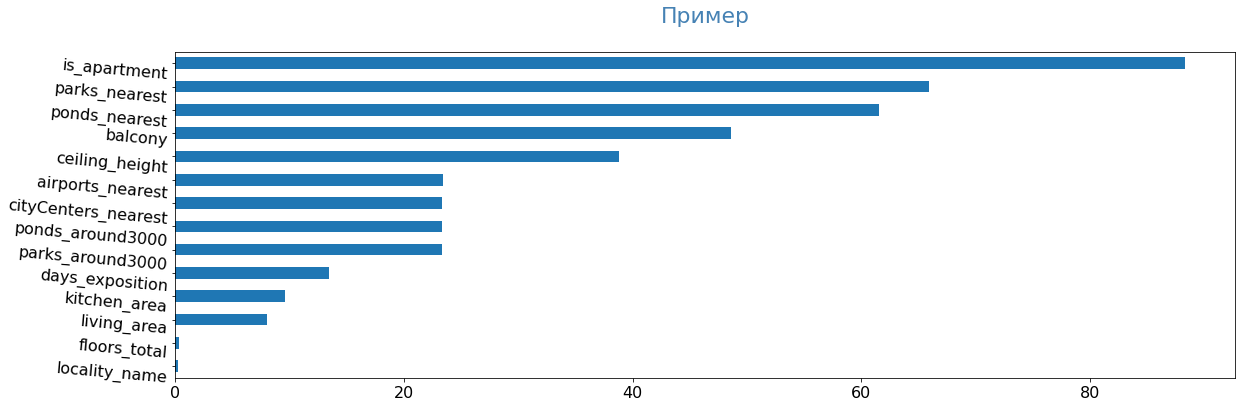

In [5]:
pass_value_barh(data)

#### Заполнение пустых значений в столбцах

Заполним пропуски в столбцах не требующих вычислений

Заполним пустые значения в столбце is_apartment и сразу же проверим результат

In [6]:
display(data['is_apartment'].value_counts())
data['is_apartment'] = data['is_apartment'].fillna(False)
display(data['is_apartment'].value_counts())

False    2725
True       50
Name: is_apartment, dtype: int64

False    23649
True        50
Name: is_apartment, dtype: int64

Заполним пустые значения в столбце balcony и сразу же проверим результат

In [7]:
display(data['balcony'].value_counts())
data['balcony'] = data['balcony'].fillna(0)
display(data['balcony'].value_counts())

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

Заполним пустые значения в столбце parks_around3000 и сразу же проверим результат

In [8]:
display(data['parks_around3000'].value_counts())
data['parks_around3000'] = data['parks_around3000'].fillna(0)
display(data['parks_around3000'].value_counts())

0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: parks_around3000, dtype: int64

0.0    15624
1.0     5681
2.0     1747
3.0      647
Name: parks_around3000, dtype: int64

Заполним пустые значения в столбце parks_nearest и сразу же проведем проверку есть ли для нулевых значениях parks_nearest не нулевые значения в parks_around3000 и наоборот.

In [9]:
data['parks_nearest'] = data['parks_nearest'].fillna(0)
display(data['parks_around3000'][data['parks_nearest'] == 0].value_counts())
display(data['parks_nearest'][data['parks_around3000'] == 0].value_counts())

0.0    15620
Name: parks_around3000, dtype: int64

0.0       15620
3190.0        2
3013.0        1
3064.0        1
Name: parks_nearest, dtype: int64

Если parks_nearest стоит нулевое значение, то по близости нет парков отображенных в столбце parks_around3000. Однако если в столбце parks_around3000 нулевое значение, есть 4 строки в parks_nearest которые превышают заданные 3км от квартиры

Заполним пустые значения в столбце ponds_around3000 и сразу же проверим результат

In [10]:
display(data['ponds_around3000'].value_counts())
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
display(data['ponds_around3000'].value_counts())

0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: ponds_around3000, dtype: int64

0.0    14589
1.0     5717
2.0     1892
3.0     1501
Name: ponds_around3000, dtype: int64

То же самое для ponds_nearest и проверка значений

In [11]:
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)
display(data['ponds_around3000'][data['ponds_nearest'] == 0].value_counts())
display(data['ponds_nearest'][data['ponds_around3000'] == 0].value_counts())

0.0    14589
Name: ponds_around3000, dtype: int64

0.0    14589
Name: ponds_nearest, dtype: int64

Для нулевых значений ponds_nearest соответствуют нулевые значения ponds_around3000 и наоборот.

Заполним пустые значения встолбце floors_total выбивающимся значением, которое в дальнейшем не будет учитываться в рассчетах.

In [12]:
display(data['floors_total'].isna().sum())
data['floors_total'] = data['floors_total'].fillna(-1)
display(data['floors_total'].isna().sum())

86

0

Заполним пропуски locality_name на "Не заданно"

In [13]:
display(data['locality_name'].isna().sum())
data['locality_name'] = data['locality_name'].fillna('Не заданно')
display(data['locality_name'].isna().sum())

49

0

Заполним пропуски в столбцах airports_nearest, cityCenters_nearest на нулевые значения и проверим результат

In [14]:
display(data['airports_nearest'].isna().sum())
data['airports_nearest'] = data['airports_nearest'].fillna(0)
display(data['airports_nearest'][data['airports_nearest'] == 0].count())

5542

5543

In [15]:
display(data['cityCenters_nearest'].isna().sum())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
display(data['cityCenters_nearest'][data['cityCenters_nearest'] == 0].count())

5519

5519

Пропуски в столбце days_exposition означают, что объъявление не закрыто и квартира не продана, следует оставить пропуски, что-бы не внести изменения в данные.

In [16]:
display(data['days_exposition'].isna().sum())

3181

Заполним пропуски в столбце ceiling_height средним значением высоты в зависимости от удаления от центра

In [17]:
print('Пустых строк:', data['ceiling_height'].isna().sum())
data['ceiling_height'] = data['ceiling_height'].fillna(0)

for i in data['cityCenters_nearest'].unique():
    data.loc[((data['ceiling_height'] == 0) & (data['cityCenters_nearest'] == i)), ['ceiling_height']] = (
        round(data['ceiling_height'][(data['ceiling_height'] != 0)&(data['cityCenters_nearest'] == i)].mean(), 2)
    )
    
data['ceiling_height'] = round(data['ceiling_height'], 2)
print('Нулевых значений в столбце:', data['ceiling_height'][data['ceiling_height'] == 0].count())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print('Пустых строк после заполнения:', data['ceiling_height'].isna().sum())

Пустых строк: 9195
Нулевых значений в столбце: 0
Пустых строк после заполнения: 0


Заполним пропуски в столбцах living_area, kitchen_area средними значениями отношения площади столбца к общей площади и проверим результат

In [18]:
print('Колличество строк сумма жилой площади и кухни превышает 90% от общей:', 
    data['total_area'][
        (data['living_area'] + data['kitchen_area'] >= data['total_area'] * 0.9) &
        ((data['kitchen_area'].notna() | (data['living_area'].notna())))
    ].count()
)
# 475 строк по формуле total_area*0.9 <= (living_area + kitchen_area) до заполнения пропусков

print('Колличество строк сумма жилой площади и кухни превышает 100% от общей:', 
    data['total_area'][
        (data['living_area'] + data['kitchen_area'] > data['total_area']) &
        ((data['kitchen_area'].notna() | (data['living_area'].notna())))
    ].count()
)

print('Отношение площади кухни к общей площади:', round(data['kitchen_area'].sum() / data['total_area'].sum(), 2))
print('Отношение жилой площади к общей площади:', round(data['living_area'].sum() / data['total_area'].sum(), 2))
print('Колличество пустых значений в столбце kitchen_area:', data['kitchen_area'].isna().sum())
print('Колличество пустых значений в столбце living_area:', data['living_area'].isna().sum())

data.loc[(data['kitchen_area'].isna()) & (data['living_area'].notna()), ['kitchen_area']] = (
   round((data['total_area'] - data['living_area'])/2, 2)
)

data.loc[(data['living_area'].isna()) & (data['kitchen_area'].notna()), ['living_area']] = (
    round(data['total_area'] * 0.8 - data['kitchen_area'], 2)
)

data['kitchen_area'] = data['kitchen_area'].fillna(round(data['total_area'] * data['kitchen_area'].sum() / data['total_area'].sum(), 2))
data['living_area'] = data['living_area'].fillna(round(data['total_area'] * data['living_area'].sum() / data['total_area'].sum(), 2))
    
print('Колличество пустых значений в столбце kitchen_area:', data['kitchen_area'].isna().sum())
print('Колличество пустых значений в столбце living_area:', data['living_area'].isna().sum()) 
print('Отношение площади кухни к общей площади:', round(data['kitchen_area'].sum() / data['total_area'].sum(), 2))
print('Отношение жилой площади к общей площади:', round(data['living_area'].sum() / data['total_area'].sum(), 2))


Колличество строк сумма жилой площади и кухни превышает 90% от общей: 475
Колличество строк сумма жилой площади и кухни превышает 100% от общей: 64
Отношение площади кухни к общей площади: 0.16
Отношение жилой площади к общей площади: 0.53
Колличество пустых значений в столбце kitchen_area: 2278
Колличество пустых значений в столбце living_area: 1903
Колличество пустых значений в столбце kitchen_area: 0
Колличество пустых значений в столбце living_area: 0
Отношение площади кухни к общей площади: 0.17
Отношение жилой площади к общей площади: 0.57


Проведем проверку корректности заполнения пропусков в столбцах living_area и kitchen_area

In [19]:
display(data['total_area'][data['living_area'] + data['kitchen_area'] >= data['total_area'] * 0.9].count())
display(data['total_area'][data['living_area'] + data['kitchen_area'] > data['total_area']].count())


539

64

Уберем из датасета строки сумма жилой площади и кухни которых превышает 100% от общей

In [20]:
alllines = data['living_area'].count()
data = data[data['living_area'] + data['kitchen_area'] <= data['total_area']].reset_index(drop=True)

display(data['total_area'][data['living_area'] + data['kitchen_area'] > data['total_area']].count())

0

In [21]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23635 entries, 0 to 23634
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23635 non-null  int64  
 1   last_price            23635 non-null  float64
 2   total_area            23635 non-null  float64
 3   first_day_exposition  23635 non-null  object 
 4   rooms                 23635 non-null  int64  
 5   ceiling_height        23635 non-null  float64
 6   floors_total          23635 non-null  float64
 7   living_area           23635 non-null  float64
 8   floor                 23635 non-null  int64  
 9   is_apartment          23635 non-null  bool   
 10  studio                23635 non-null  bool   
 11  open_plan             23635 non-null  bool   
 12  kitchen_area          23635 non-null  float64
 13  balcony               23635 non-null  float64
 14  locality_name         23635 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,...,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.70,11.0,18.60,1,False,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,0.0,0.0,0.0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.70,5.0,34.30,4,False,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,3.00,14.0,85.61,9,False,...,26.01,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,...,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Пропуски во всех стобцах заполненны и не пустые значения не затронуты, во время заполнения.

In [22]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0, 0.0012, 0.01, .5, .99, .9988, 1.0]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0,0.00,12.00,1.00,1.00,"12,190.00",2.00,0.00,1.00,-1.00
0.0012,0.00,20.00,2.40,3.00,"561,804.00",9.04,2.00,1.00,-1.00
0.01,1.00,25.28,2.50,4.00,"1,000,000.00",13.00,4.00,1.00,2.00
0.5,2.00,52.00,2.70,95.00,"4,650,000.00",30.00,9.00,4.00,9.00
0.99,5.00,197.66,3.74,"1,069.00","36,000,000.00",122.07,35.50,23.00,26.00
0.9988,8.00,380.00,14.00,"1,370.23","124,812,384.00",229.03,63.26,26.00,34.64
1.0,19.00,900.00,100.00,"1,580.00","763,000,000.00",444.80,115.00,33.00,60.00


#### Изменение типов данных

Исправим не соответствующие типы данных для столбцов.

Столбцы last_price, floors_total, balcony, parks_around3000, ponds_around3000, days_exposition, parks_nearest, ponds_nearest, airports_nearest, cityCenters_nearest можно привести к целочисленному типу, т.к. из значение конкретное число или значение которое можно округлить до целого числа.

Столбец first_day_exposition нужно привести к типу datetime, причем можно отбросить время, т.к. в исследовании оно нам не нужно, и в таблице нет данных по времени.

In [23]:
for column in ['last_price', 'floors_total', 'balcony', 'parks_around3000', 'ponds_around3000',
               'parks_nearest', 'ponds_nearest', 'airports_nearest',
               'cityCenters_nearest']:
    data[column] = data[column].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23635 entries, 0 to 23634
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23635 non-null  int64         
 1   last_price            23635 non-null  int64         
 2   total_area            23635 non-null  float64       
 3   first_day_exposition  23635 non-null  datetime64[ns]
 4   rooms                 23635 non-null  int64         
 5   ceiling_height        23635 non-null  float64       
 6   floors_total          23635 non-null  int64         
 7   living_area           23635 non-null  float64       
 8   floor                 23635 non-null  int64         
 9   is_apartment          23635 non-null  bool          
 10  studio                23635 non-null  bool          
 11  open_plan             23635 non-null  bool          
 12  kitchen_area          23635 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.00,8,False,...,25.00,0,Санкт-Петербург,18863,16028,1,482,2,755,NaN
1,7,3350000,40.4,2018-12-04,1,2.70,11,18.60,1,False,...,11.00,2,посёлок Шушары,12817,18603,0,0,0,0,81.0
2,10,5196000,56.0,2015-08-20,2,2.70,5,34.30,4,False,...,8.30,0,Санкт-Петербург,21741,13933,1,90,2,574,558.0
3,0,64900000,159.0,2015-07-24,3,3.00,14,85.61,9,False,...,26.01,0,Санкт-Петербург,28098,6800,2,84,3,234,424.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.00,13,False,...,41.00,0,Санкт-Петербург,31856,8098,2,112,1,48,121.0


#### Дубликаты и неявные дубликаты

Проверим датафрейм на наличие дубликатов

Не явные дубликаты стоит искать в столбце с названиями населенных пунктов locality_name

In [24]:
print('Полных дубликатов строк:', data.duplicated().sum())
print('Уникальных населенных пунктов:', data['locality_name'].value_counts().count())
data['locality_name'].unique()

Полных дубликатов строк: 0
Уникальных населенных пунктов: 365


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Уберем из названий тип населенного пункта, оставив только одно название.

In [25]:
duplicates = ['поселок городского типа ', 'посёлок городского типа ', 'городской поселок ',  'городской посёлок ', 
              'поселок городского типа имени ', 'посёлок городского типа имени ', 'посёлок ', 'поселок ', 'деревня ', 
              'садовое товарищество ', 'село ', 'имени ', 'садоводческое некоммерческое товарищество ', 'при железнодорожной станции ',
              'коттеджный посёлок', 'коттеджный поселок', 'коттеджный ', 'станции ']
for i in duplicates:
    data['locality_name'] = data['locality_name'].str.replace(i, '')

print('Уникальных населенных пунктов:', data['locality_name'].value_counts().count())
data['locality_name'].unique()

Уникальных населенных пунктов: 306


array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [26]:
# check
data['locality_name'].nunique()

306

Не явные дубликаты устранены из столбца locality_name.

Теперь можно заполнить пропущенные значения в столбцах airports_nearest, cityCenters_nearest на основе медианных значений в строках с одинаковым населенным пунктом locality_name

In [27]:
def midl_range(df):
    for i in df['locality_name'][(df['airports_nearest'] == 0) | (df['cityCenters_nearest'] == 0)]:
        midl_airport = df['airports_nearest'][df['locality_name'] == i].median()
        midl_center = df['cityCenters_nearest'][df['locality_name'] == i].median()
        if midl_airport != 0:
            df.loc[(df['locality_name'] == i) & (df['airports_nearest'] == 0), ['airports_nearest']] = midl_airport
        if midl_center != 0:
            df.loc[(df['locality_name'] == i) & (df['cityCenters_nearest'] == 0), ['cityCenters_nearest']] = midl_center
    return df

display(data['airports_nearest'][data['airports_nearest'] == 0].count())
display(data['cityCenters_nearest'][data['cityCenters_nearest'] == 0].count())
#data = data.apply(midl_range, axis=1) через метод apply реализовать не получилось
for i in data['locality_name'][(data['airports_nearest'] == 0) | (data['cityCenters_nearest'] == 0)]:
    midl_airport = data['airports_nearest'][data['locality_name'] == i].median()
    midl_center = data['cityCenters_nearest'][data['locality_name'] == i].median()
    if midl_airport != 0:
        data.loc[(data['locality_name'] == i) & (data['airports_nearest'] == 0), ['airports_nearest']] = midl_airport
    if midl_center != 0:
        data.loc[(data['locality_name'] == i) & (data['cityCenters_nearest'] == 0), ['cityCenters_nearest']] = midl_center
display(data['airports_nearest'][data['airports_nearest'] == 0].count())
display(data['cityCenters_nearest'][data['cityCenters_nearest'] == 0].count())

5523

5499

5420

5420

В столбце ceiling_height присутствуют значения, в которых явно присутствует ошибка при вводе данных, отсутствует запятая для дробной части. Поделим значения в столбце больше 20 на 10. Проверим оставшиеся значения больше четырех в столбце

In [28]:
display(data['ceiling_height'][data['ceiling_height'] > 10].value_counts())
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10, 'ceiling_height'] / 10
display(data['ceiling_height'][data['ceiling_height'] > 4].value_counts())

27.00     9
25.00     8
15.12     3
14.00     2
22.60     2
32.00     2
20.00     1
24.00     1
10.30     1
26.00     1
100.00    1
Name: ceiling_height, dtype: int64

4.82     15
4.20     11
4.50      7
4.40      5
6.26      4
4.10      4
8.00      3
4.15      3
5.30      3
4.05      2
4.14      2
4.70      2
4.19      2
4.45      2
5.75      2
4.65      1
4.30      1
6.00      1
8.30      1
5.60      1
4.90      1
5.20      1
4.37      1
5.00      1
5.80      1
5.50      1
4.80      1
4.06      1
10.00     1
4.24      1
4.25      1
Name: ceiling_height, dtype: int64

#### Редкие и выбивающиеся значения

Построим гистограмму столбца total_images для проверки выбивающихся значений.

75

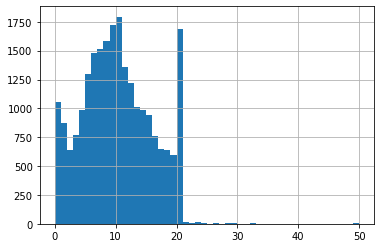

In [29]:
data['total_images'].hist(bins=50)
display(data['total_images'][data['total_images'] > 20].count())

На графие видно что значения выше 20 практически равны нулю и их общее колличество (75) не влияют на результаты исследования если их отбросить.

Отфильтруем в новый датафрейм значения из столбца total_images меньше 20

0.59 % выбоки удалено


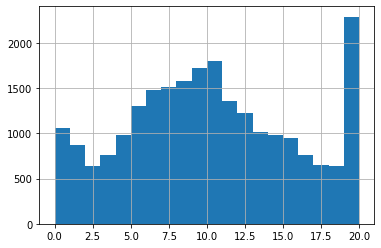

In [30]:
filtered_df = data.loc[data['total_images'] < 21]
filtered_df['total_images'].hist(bins=20)
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

Проверим выбивающиеся значения в столюце last_price, посчитаем колличество строк для крайних дипазонов на графике от 10 млн до 20 млн, от 20 млн до 30 млн, более 30 млн.

1977

376

314

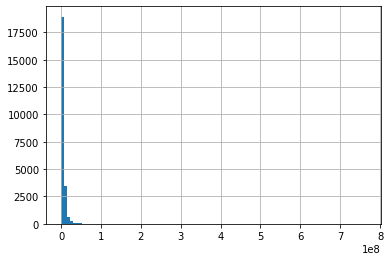

In [31]:
filtered_df['last_price'].hist(bins=100)
display(filtered_df['last_price'][(filtered_df['last_price'] > 10000000) & (filtered_df['last_price'] < 20000000)].count())
display(filtered_df['last_price'][(filtered_df['last_price'] > 20000000) & (filtered_df['last_price'] < 30000000)].count())
display(filtered_df['last_price'][filtered_df['last_price'] > 30000000].count())

Квартир с ценой более 30 млн нашлось 314 строк. Эти значения можно считать выбивающимися и аномально высокими, можно отфильтровать строки с ценой ниже 30 000 000

1.95 % выбоки удалено


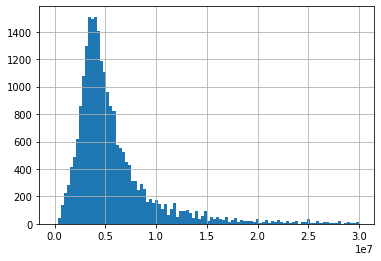

In [32]:
filtered_df = filtered_df[filtered_df['last_price'] < 30000000]
filtered_df['last_price'].hist(bins=100)
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

Проверим столбец total_area на выбивающиеся значения. Из графика видно, что значения выше 250 почти не отличимы от нуля, посчитаем колличество строк со значением больше 250.

<AxesSubplot:>

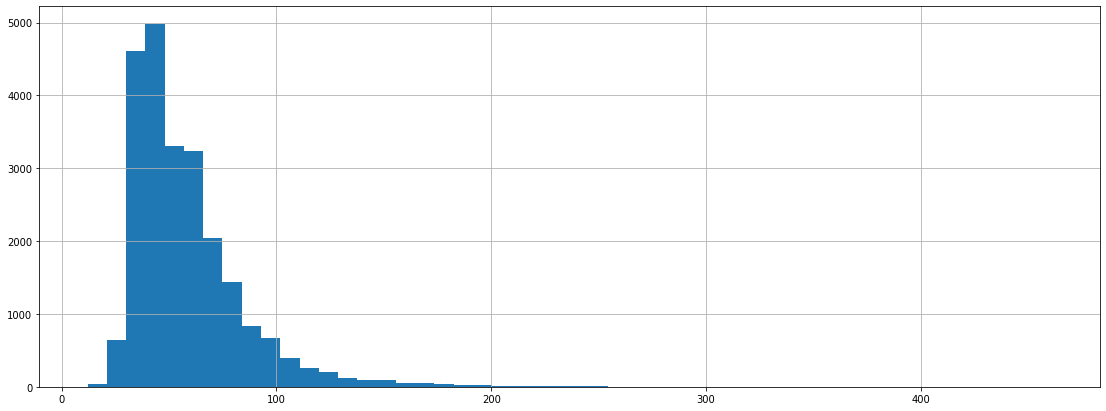

In [33]:
filtered_df['total_area'].hist(bins=50, figsize=(19,7))

57

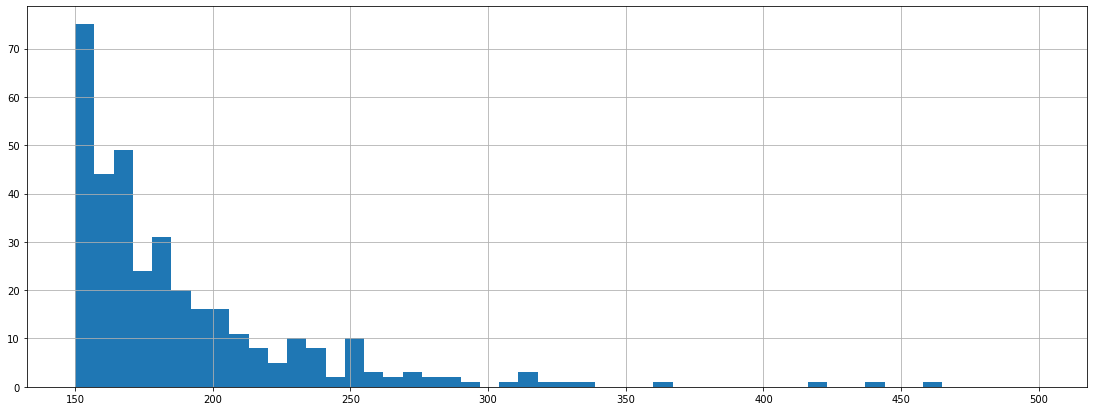

In [34]:
filtered_df['total_area'].hist(bins=50, figsize=(19,7), range=(150, 500))
filtered_df['total_area'][filtered_df['total_area'] > 220].count()

27

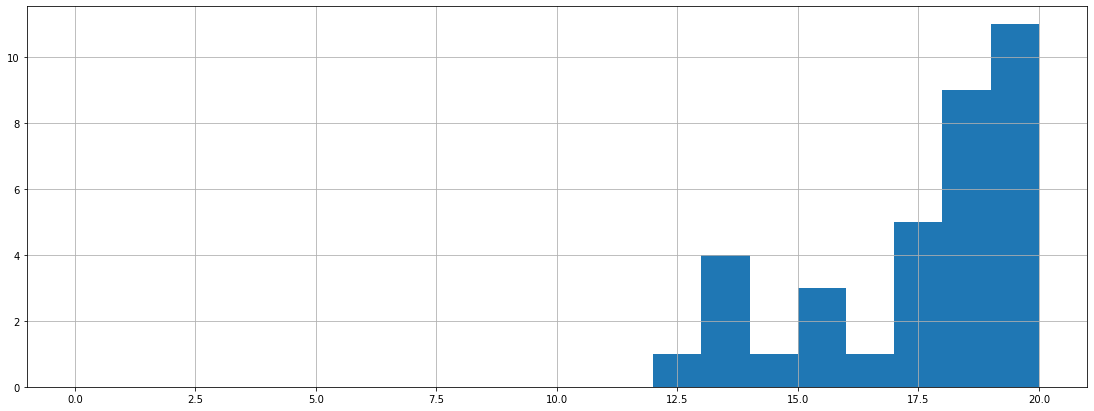

In [35]:
filtered_df['total_area'].hist(bins=20, figsize=(19,7), range=(0,20))
filtered_df['total_area'][filtered_df['total_area'] < 20].count()

Отфильтруем значения общей площади ниже 220 квадратных метров и более 18

0

659

2.77 % выбоки удалено


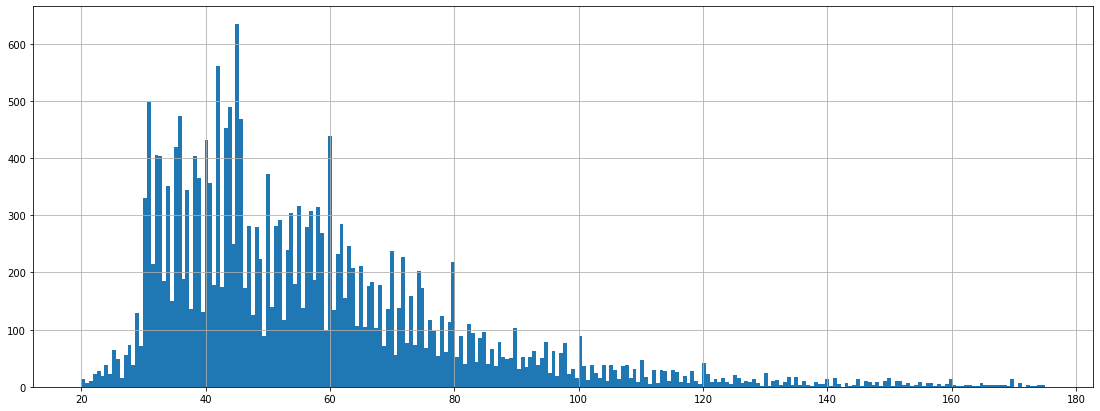

In [36]:
filtered_df = filtered_df[(filtered_df['total_area'] <= 175) & ((filtered_df['total_area'] >= 20))]
filtered_df['total_area'].hist(bins=250, figsize=(19,7))
display(filtered_df['total_area'][filtered_df['total_area'] > 175].count())
display(filtered_df['total_area'][filtered_df['total_area'] < 30].count())
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

Проверим значения в стоблце rooms, посчитаем колличество строк со значением выше 7

56

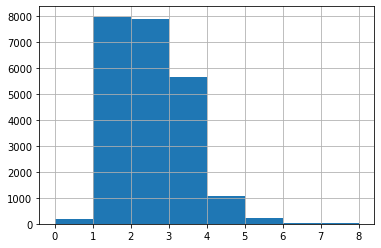

In [37]:
filtered_df['rooms'].hist(bins=8)
filtered_df['rooms'][filtered_df['rooms'] > 5].count()

Отфильтруем строки с семью комнатами и менее

187

0

223

3.01 % выбоки удалено


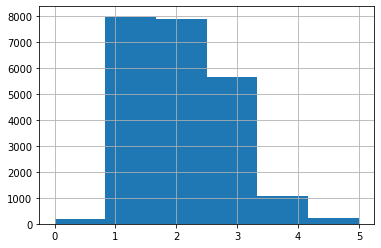

In [38]:
filtered_df = filtered_df[filtered_df['rooms'] <= 5]
filtered_df['rooms'].hist(bins=6)
display(filtered_df['rooms'][filtered_df['rooms'] == 0].count())
display(filtered_df['rooms'][filtered_df['rooms'] == 6].count())
display(filtered_df['rooms'][filtered_df['rooms'] == 5].count())
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

Проверим значения встолбце ceiling_height. На графике видно, что позиций ниже 2.4 и выше 4.5 почти нет. Посчитаем колличество этих строк.

124

97

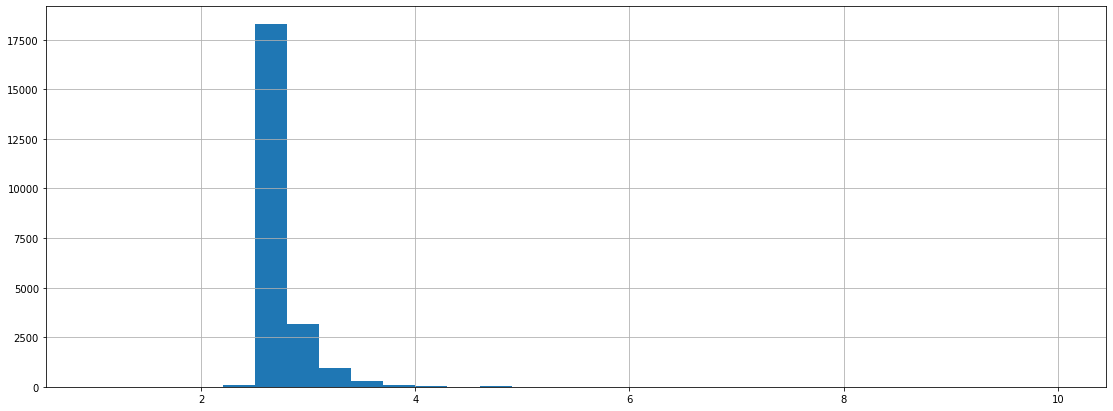

In [39]:
filtered_df['ceiling_height'].hist(bins=30, figsize=(19,7))
display(filtered_df['ceiling_height'][filtered_df['ceiling_height'] > 3.8].count())
display(filtered_df['ceiling_height'][filtered_df['ceiling_height'] < 2.49].count())

<AxesSubplot:>

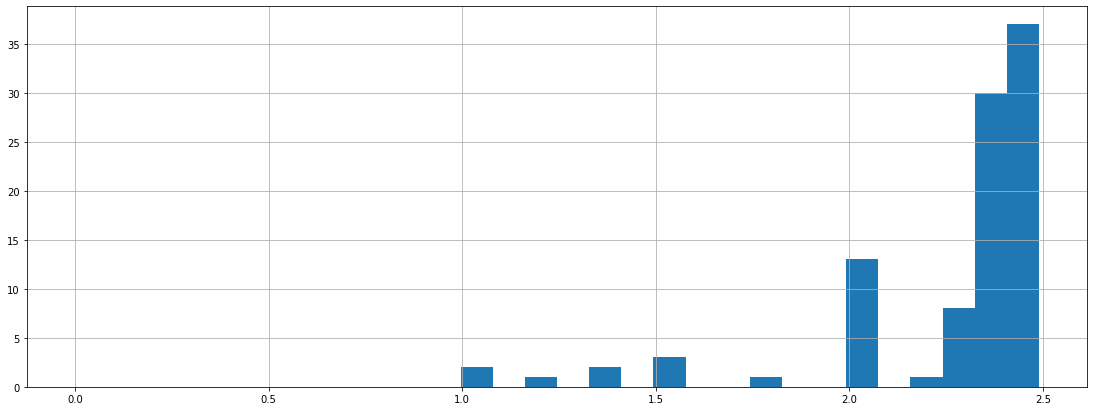

In [40]:
filtered_df['ceiling_height'].hist(bins=30, figsize=(19,7), range=(0,2.49))

<AxesSubplot:>

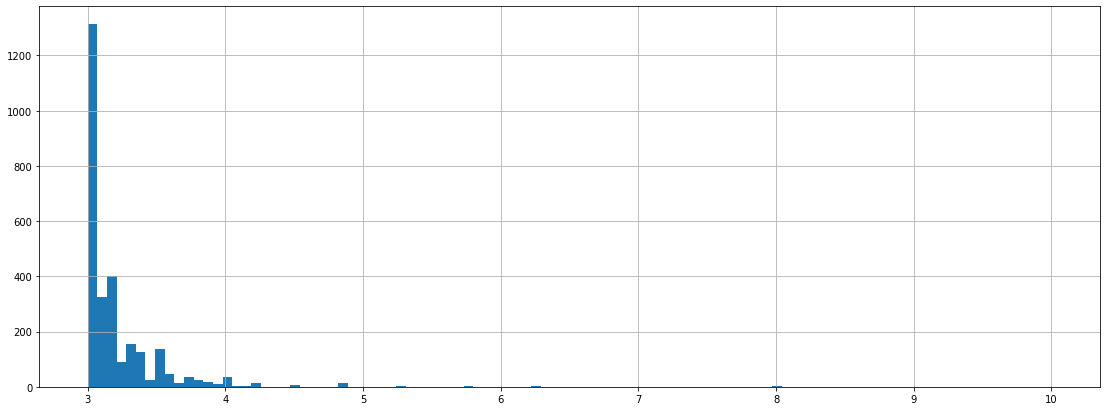

In [41]:
filtered_df['ceiling_height'].hist(bins=100, figsize=(19,7), range=(3,10))

Отфильтруем строки по высоте потолков более 2.5 метра и менее 3.6 метра

206

4.27 % выбоки удалено


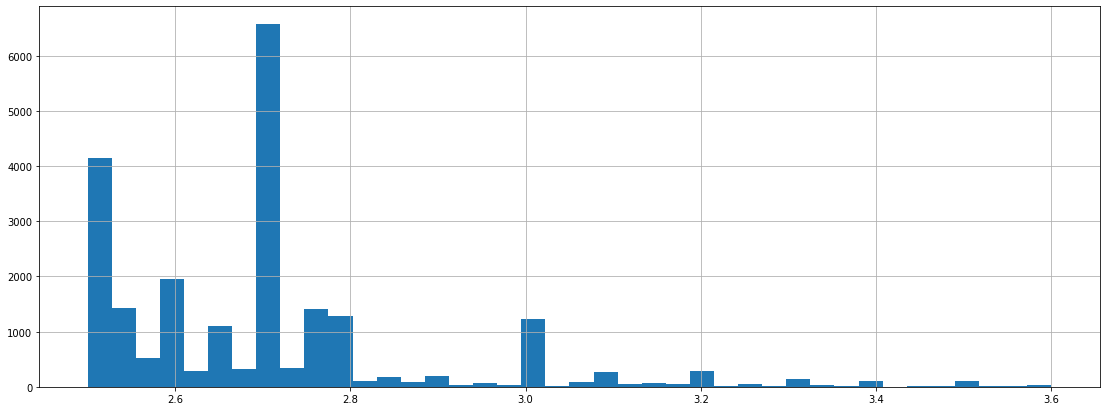

In [42]:
filtered_df = filtered_df[(filtered_df['ceiling_height'] >= 2.5) & (filtered_df['ceiling_height'] <= 3.6)]
filtered_df['ceiling_height'].hist(bins=40, figsize=(19,7))
display(filtered_df['ceiling_height'][filtered_df['ceiling_height'] > 3.4].count())
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

Проверим значения в столбце flors_total. Посчитаем колличество строк со значением более 28

37

84

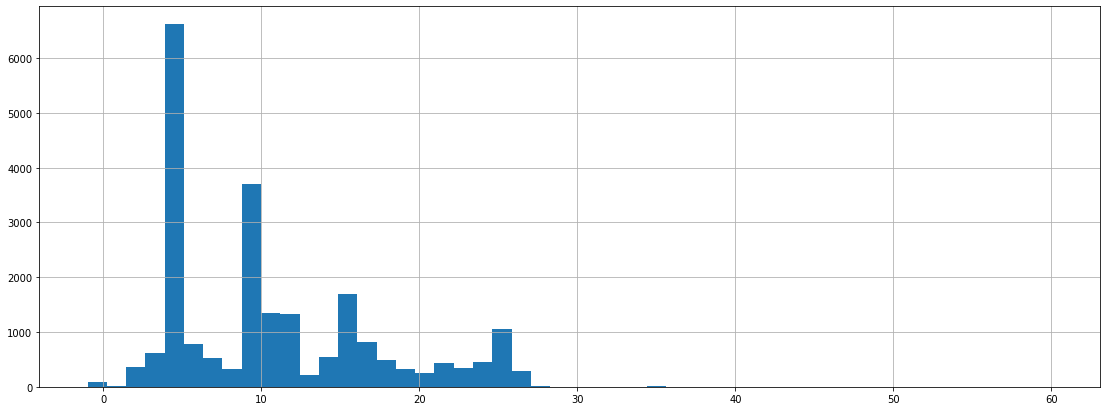

In [43]:
filtered_df['floors_total'].hist(bins=50, figsize=(19,7))
display(filtered_df['floors_total'][filtered_df['floors_total'] > 27].count())
display(filtered_df['floors_total'][filtered_df['floors_total'] == -1].count())

Отфильтруем строки с домами не более 27 этажами

4.78 % выбоки удалено


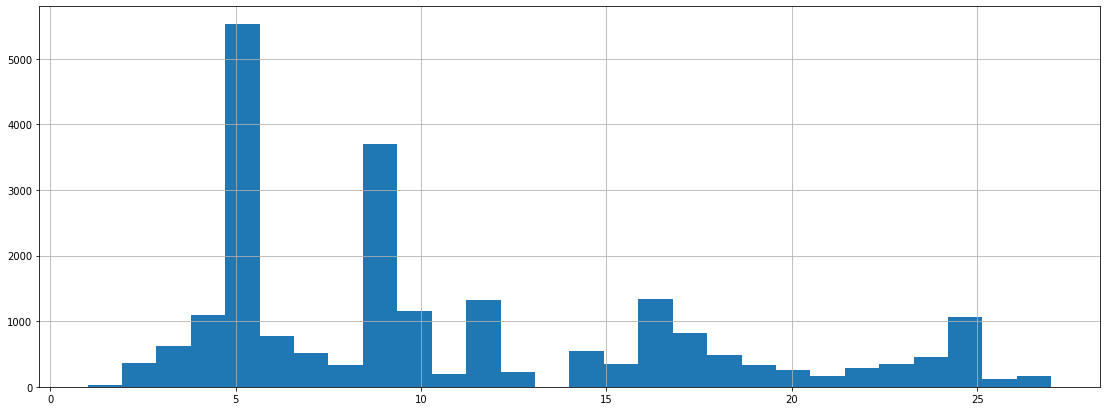

In [44]:
filtered_df = filtered_df[(filtered_df['floors_total'] <= 27) & (filtered_df['floors_total'] > 0)]
filtered_df['floors_total'].hist(bins=28, figsize=(19,7))
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

Проверим значения в столбце living_area и посчитаем строки со значением выше 160

29

24

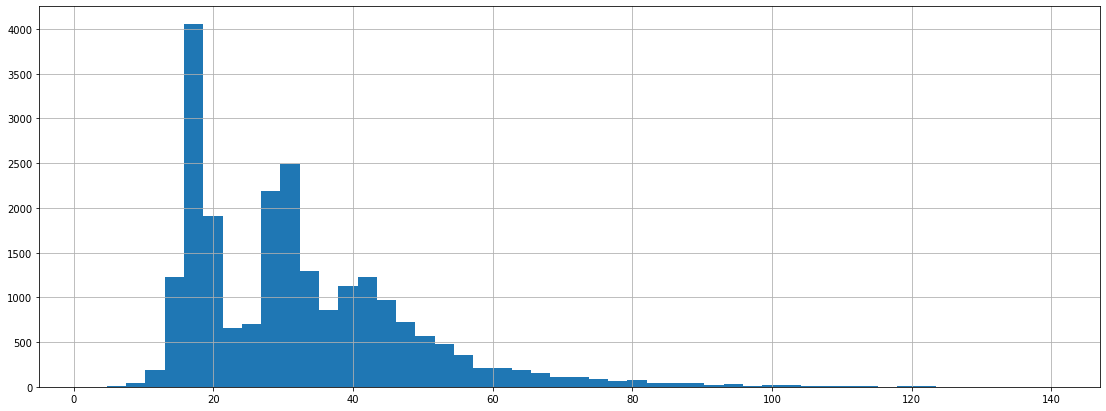

In [45]:
filtered_df['living_area'].hist(bins=50, figsize=(19,7))
display(filtered_df['living_area'][filtered_df['living_area'] >110].count())
display(filtered_df['living_area'][filtered_df['living_area'] <10].count())

24

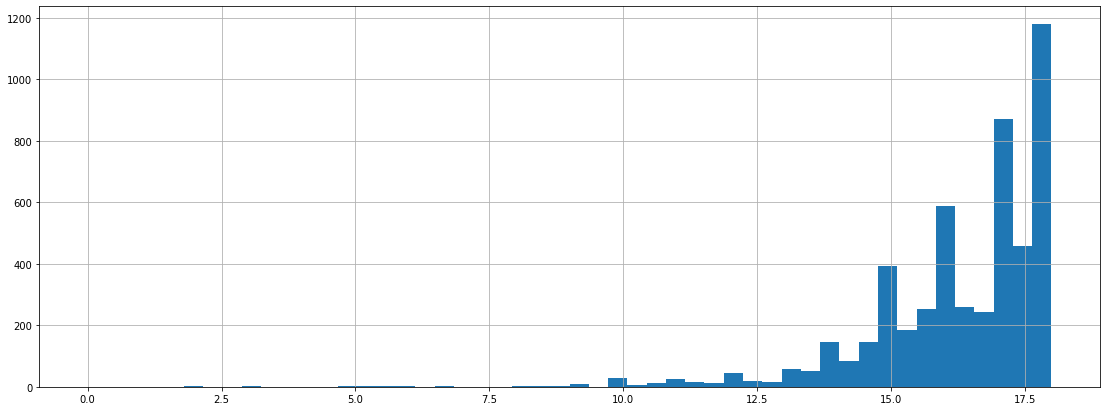

In [46]:
filtered_df['living_area'].hist(bins=50, figsize=(19,7), range=(0,18))
display(filtered_df['living_area'][filtered_df['living_area'] <10].count())

68

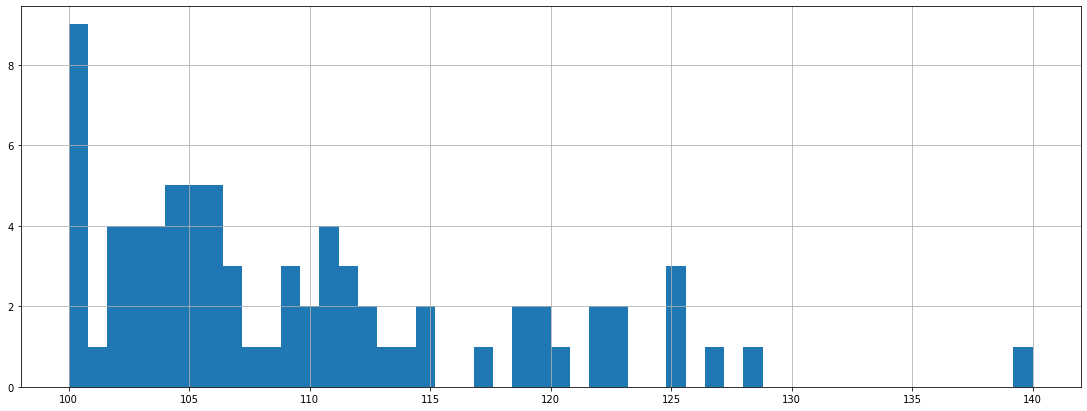

In [47]:
filtered_df['living_area'].hist(bins=50, figsize=(19,7), range=(100, 140))
display(filtered_df['living_area'][filtered_df['living_area'] > 100].count())

Отфильруем строки с жилой площадью менее 160 метров квадратных

5.17 % выбоки удалено


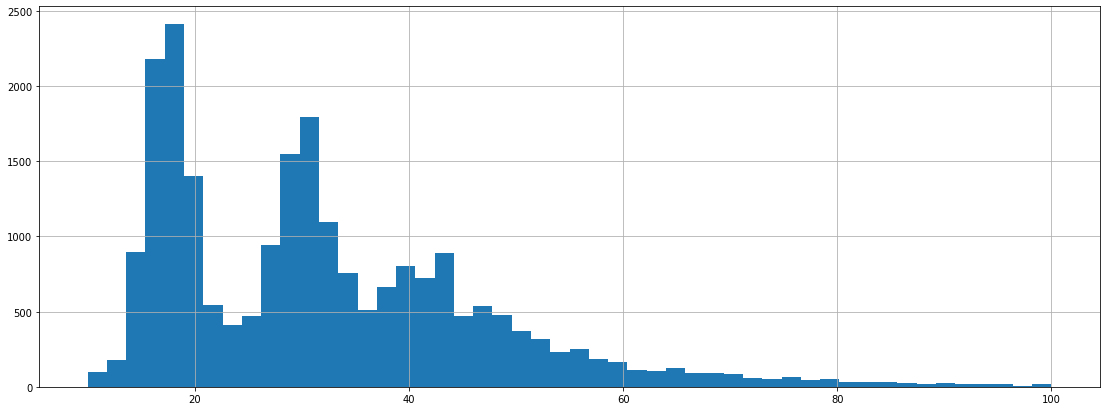

In [48]:
filtered_df = filtered_df[(filtered_df['living_area'] >= 10) & (filtered_df['living_area'] <=100)]
filtered_df['living_area'].hist(bins=50, figsize=(19,7))
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

Проверим значения в столбце floor и посчитаем колличество строк выше 25. В этом столбце аномалий не наблюдается.

26    20
27     7
Name: floor, dtype: int64

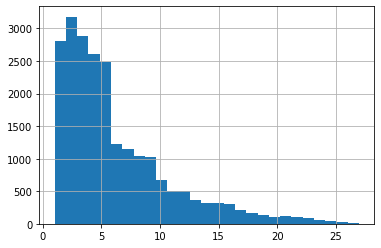

In [49]:
filtered_df['floor'].hist(bins=27)
filtered_df['floor'][filtered_df['floor'] >25].value_counts()

Проверим значения в kitchen_area и посчитаем колличество строк со значением более 50

63

16

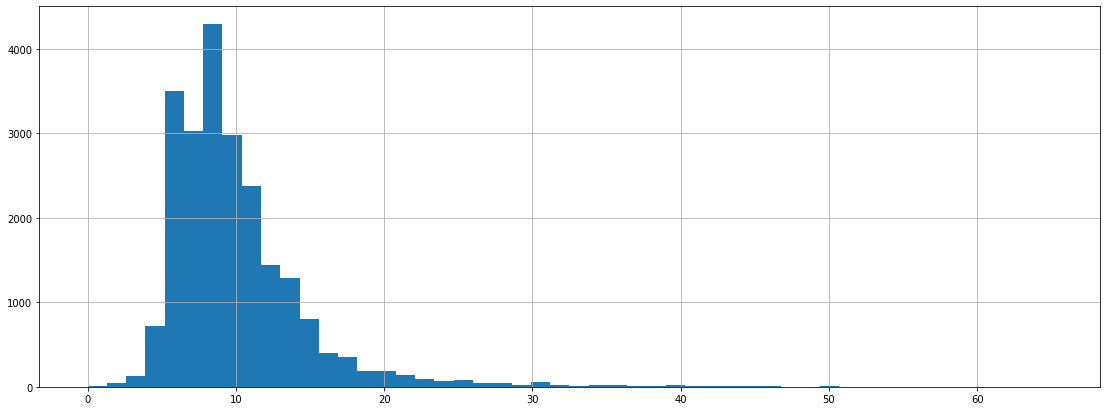

In [50]:
filtered_df['kitchen_area'].hist(bins=50, figsize=(19,7))
display(filtered_df['kitchen_area'][filtered_df['kitchen_area'] > 40].count())
display(filtered_df['kitchen_area'][filtered_df['kitchen_area'] < 2].count())

<AxesSubplot:>

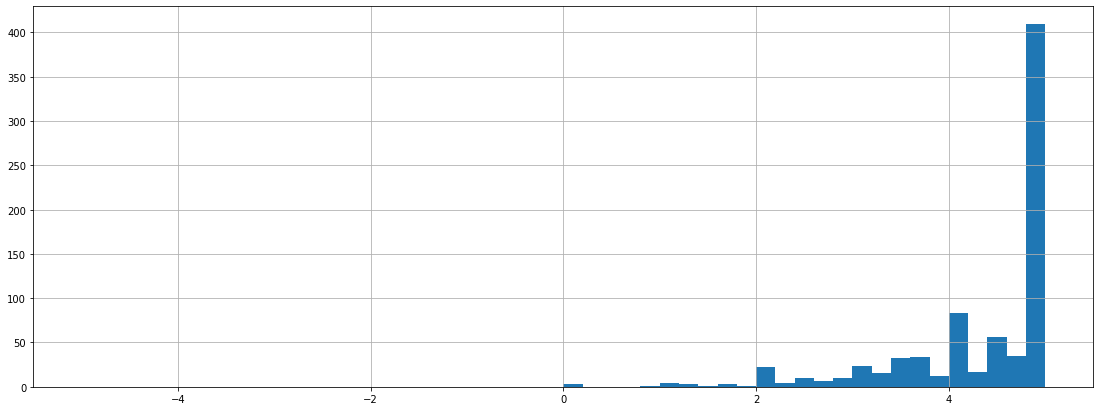

In [51]:
filtered_df['kitchen_area'].hist(bins=50, figsize=(19,7), range=(-5, 5))

<AxesSubplot:>

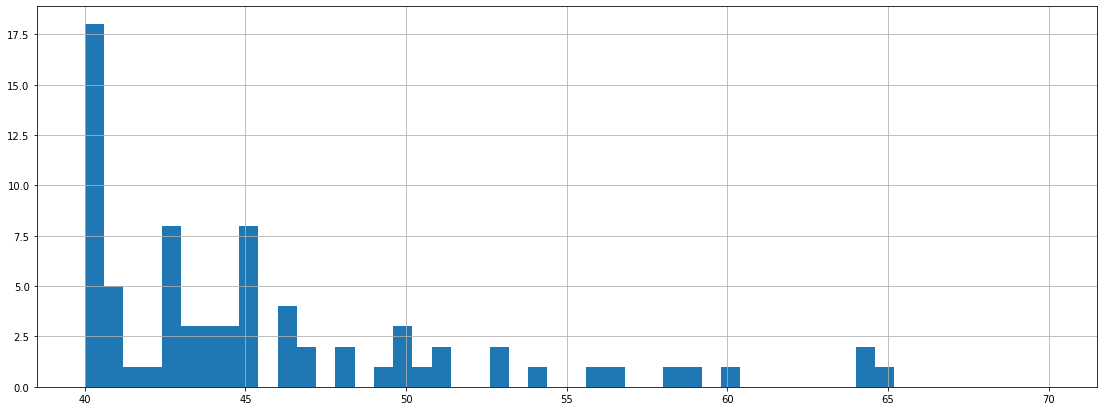

In [52]:
filtered_df['kitchen_area'].hist(bins=50, figsize=(19,7), range=(40, 70))

Отфильтруем строки с площадью кухни менее 50 метров

5.5 % выбоки удалено


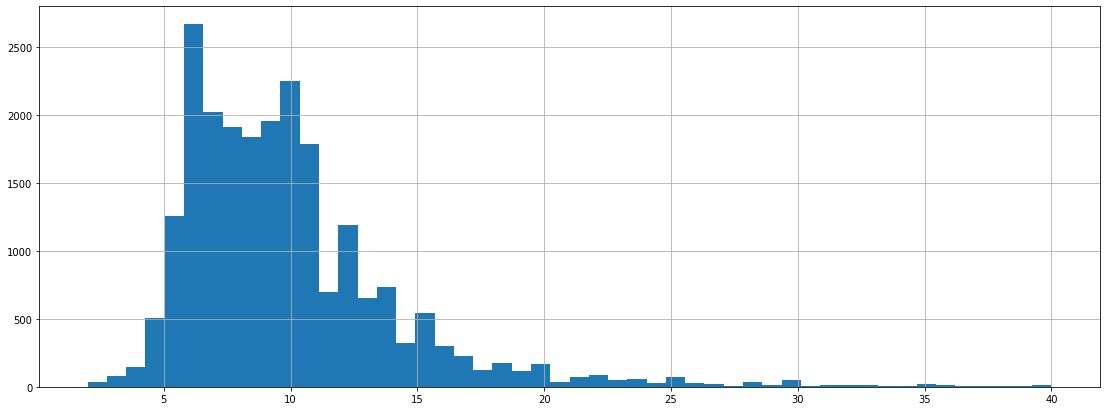

In [53]:
filtered_df = filtered_df[(filtered_df['kitchen_area'] >= 2) & (filtered_df['kitchen_area'] <= 40)]
filtered_df['kitchen_area'].hist(bins=50, figsize=(19,7))
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

Проверим значения в столбце airports_nearest, посчиатем строки значения выше 75 000 и колличество нулевых значений(пропусков)

5332

9

<AxesSubplot:>

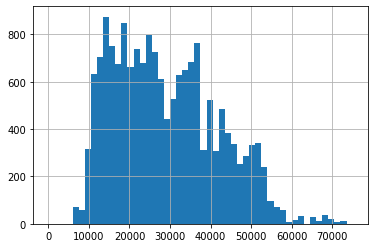

In [54]:
display(filtered_df['airports_nearest'][filtered_df['airports_nearest'] == 0].count())
display(filtered_df['airports_nearest'][filtered_df['airports_nearest'] > 75000].count())
filtered_df['airports_nearest'].hist(bins=50, range=(1, 75000))

График выглядит без аномалий

Проверим значения в столбце cityCenters_nearest, посчиатем строки значения выше 55 000 и колличество нулевых значений(пропусков)

5332

12

<AxesSubplot:>

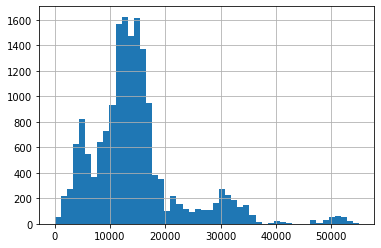

In [55]:
display(filtered_df['cityCenters_nearest'][filtered_df['cityCenters_nearest'] == 0].count())
display(filtered_df['cityCenters_nearest'][filtered_df['cityCenters_nearest'] > 55000].count())
filtered_df['cityCenters_nearest'].hist(bins=50, range=(1, 55000))

График выглядит без аномалий

Проверим значения в столбце parks_nearest, посчиатем колличество нулевых значений(пропусков)

15047

<AxesSubplot:>

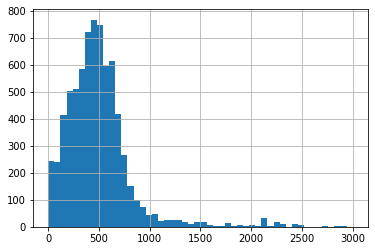

In [56]:
display(filtered_df['parks_nearest'][filtered_df['parks_nearest'] == 0].count())
filtered_df['parks_nearest'].hist(bins=50, range=(1, 3000))

Проверим значения в столбце ponds_nearest, посчиатем колличество нулевых значений(пропусков)

14075

<AxesSubplot:>

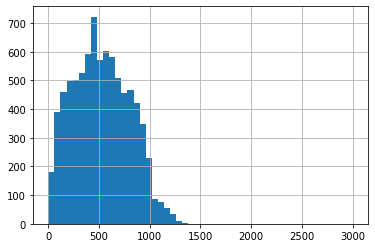

In [57]:
display(filtered_df['ponds_nearest'][filtered_df['ponds_nearest'] == 0].count())
filtered_df['ponds_nearest'].hist(bins=50, range=(1, 3000))

Отфильтруем пропущенные значения из столбца locality_name

In [58]:
filtered_df = filtered_df[filtered_df['locality_name'] != 'Не заданно']
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

5.7 % выбоки удалено


<AxesSubplot:>

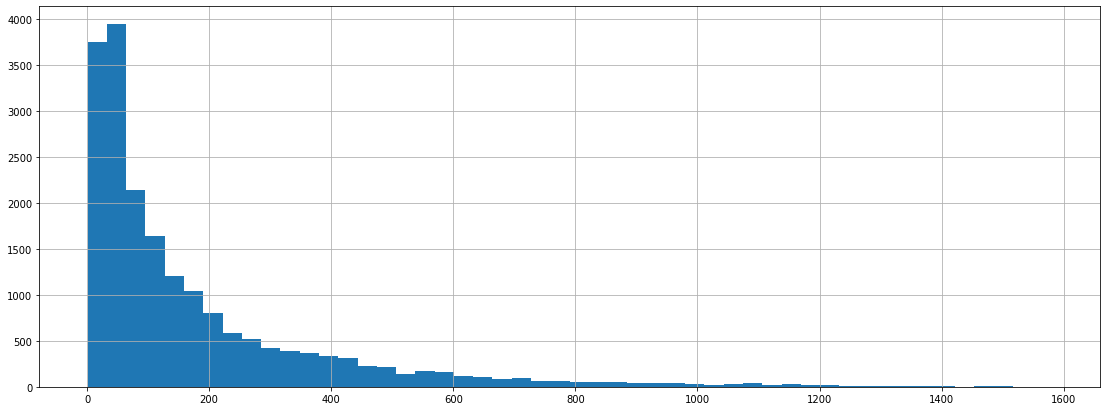

In [59]:
filtered_df['days_exposition'].hist(bins=50, figsize=(19,7))

4

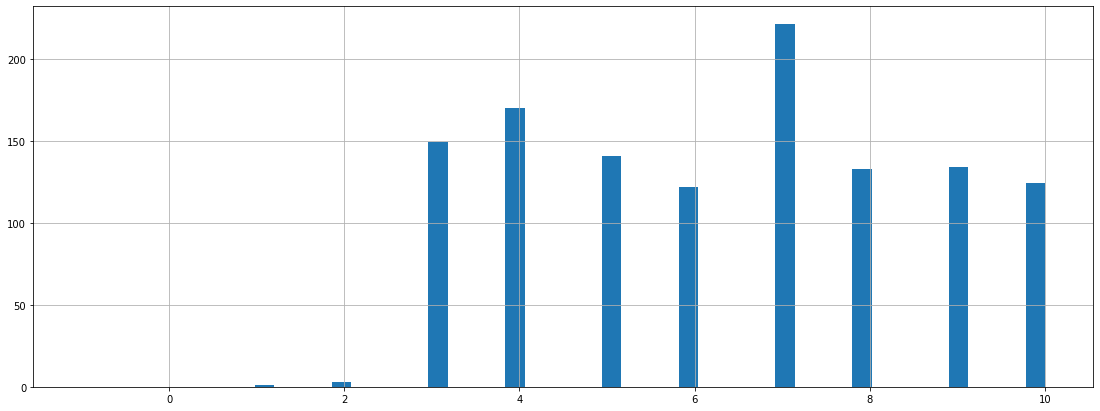

In [60]:
filtered_df['days_exposition'].hist(bins=50, figsize=(19,7), range=(-1,10))
display(filtered_df['days_exposition'][filtered_df['days_exposition'] < 3].count())

58

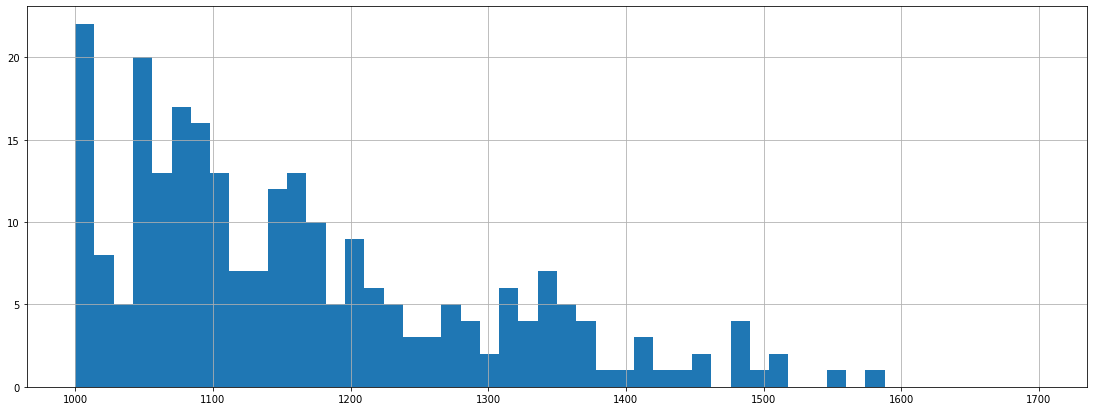

In [61]:
filtered_df['days_exposition'].hist(bins=50, figsize=(19,7), range=(1000, 1700))
display(filtered_df['days_exposition'][filtered_df['days_exposition'] > 1250].count())

In [62]:
filtered_df = filtered_df[((filtered_df['days_exposition'] >= 3) & (filtered_df['days_exposition'] <= 1250)) | (filtered_df['days_exposition'].isna())]
print(round((alllines -filtered_df['total_images'].count()) / alllines*100, 2), '% выбоки удалено')

5.96 % выбоки удалено


In [63]:
filtered_df = filtered_df.reset_index(drop=True)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22287 entries, 0 to 22286
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22287 non-null  int64         
 1   last_price            22287 non-null  int64         
 2   total_area            22287 non-null  float64       
 3   first_day_exposition  22287 non-null  datetime64[ns]
 4   rooms                 22287 non-null  int64         
 5   ceiling_height        22287 non-null  float64       
 6   floors_total          22287 non-null  int64         
 7   living_area           22287 non-null  float64       
 8   floor                 22287 non-null  int64         
 9   is_apartment          22287 non-null  bool          
 10  studio                22287 non-null  bool          
 11  open_plan             22287 non-null  bool          
 12  kitchen_area          22287 non-null  float64       
 13  balcony         

Из отфильтрованного датафрейма ушло 1354 строки. Это около 6% от исходной выборки.

In [64]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,635.00","23,635.00","23,635.00","20,462.00","23,635.00","23,635.00","23,635.00","23,635.00","23,635.00"
min,0.00,12.00,1.00,1.00,"12,190.00",2.00,0.00,1.00,-1.00
max,19.00,900.00,10.00,"1,580.00","763,000,000.00",444.80,115.00,33.00,60.00


In [65]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир

(
    filtered_df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,287.00","22,287.00","22,287.00","19,366.00","22,287.00","22,287.00","22,287.00","22,287.00","22,287.00"
min,0.00,20.00,2.50,3.00,"430,000.00",10.00,2.00,1.00,1.00
max,5.00,175.00,3.60,"1,240.00","29,999,000.00",100.00,40.00,27.00,27.00


In [66]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,8016
2,7918
3,5803
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


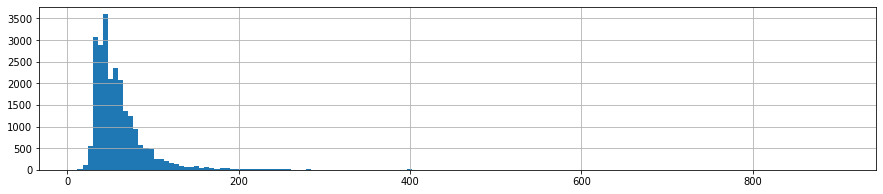

In [67]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

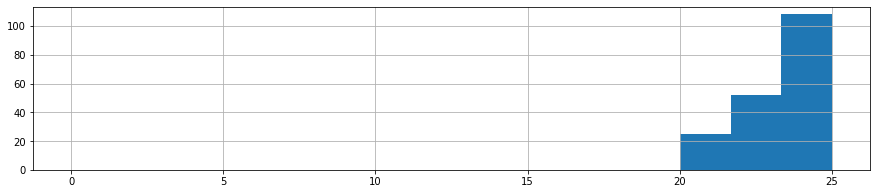

In [68]:
# check
filtered_df.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [69]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,20.00,2.30,3.00,"561,804.00",9.04,2.00,1.00,-1.00
0.01,1.00,25.28,2.50,4.00,"1,000,000.00",13.00,4.00,1.00,2.00
0.5,2.00,52.00,2.70,95.00,"4,650,000.00",30.00,9.00,4.00,9.00
0.99,5.00,197.66,3.70,"1,069.00","36,000,000.00",122.07,35.50,23.00,26.00
0.9988,8.00,380.00,4.82,"1,370.23","124,812,384.00",229.03,63.26,26.00,34.64


### Посчитайте и добавьте в таблицу новые столбцы

In [70]:
filtered_df['metre_price']=round(filtered_df['last_price'] / filtered_df['total_area'])
filtered_df['metre_price'] = filtered_df['metre_price'].astype('int')
filtered_df['week_day_exposition'] = filtered_df['first_day_exposition'].dt.weekday
filtered_df['mounth_exposition'] = filtered_df['first_day_exposition'].dt.month
filtered_df['year_exposition'] = filtered_df['first_day_exposition'].dt.year

def floor_type(floor):
    if floor['floor'] == 1:
        return 'первый'
    elif floor['floors_total'] == floor['floor']:
        return 'последний'
    elif floor['floors_total'] == 0:
        return ' подвал'
    elif floor['floors_total'] < 0:
        return ' минусовой'
    else:
        return 'другой'

filtered_df['floor_type'] = filtered_df.apply(floor_type, axis=1)

filtered_df['cityCenters_kmetres'] = round(filtered_df['cityCenters_nearest'] / 1000, 0).astype(int)

filtered_df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metre_price,week_day_exposition,mounth_exposition,year_exposition,floor_type,cityCenters_kmetres
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482,2,755,NaN,120370,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.70,11,18.6,1,False,...,0,0,0,81.0,82921,1,12,2018,первый,19
2,10,5196000,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,90,2,574,558.0,92786,3,8,2015,другой,14
3,10,2890000,30.4,2018-09-10,1,2.71,12,14.4,5,False,...,0,0,0,55.0,95066,0,9,2018,другой,0
4,6,3700000,37.3,2017-11-02,1,2.62,26,10.6,6,False,...,0,0,0,155.0,99196,3,11,2017,другой,19


### Проведите исследовательский анализ данных

#### Построим гистограммы целевых столбцов 

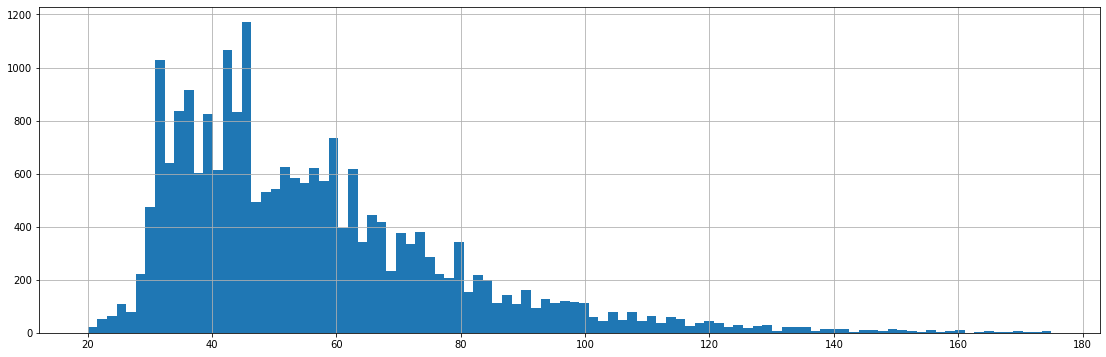

In [71]:
filtered_df['total_area'].hist(bins=100, figsize=(19,6));

Общая площадь распределена по диапозону 20 - 180 метров квадратных с пиком в районе 45 метров квадратных

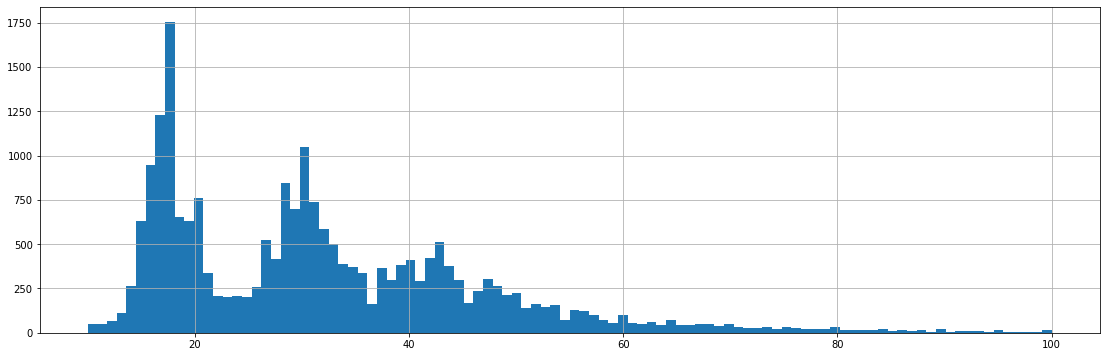

In [72]:
filtered_df['living_area'].hist(bins=100, figsize=(19,6));

Жилая площаль распределена в диапазоне 10 - 100 метров квадратных с пиком в районе 18 метров квадратных, меньшим пиком в районе 30 метров квадратных и третьим пиком в районе 43 метров квадратных.

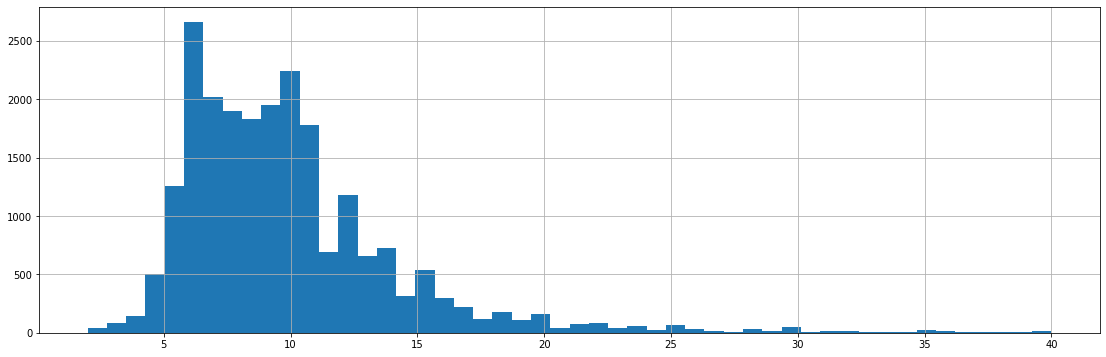

In [73]:
filtered_df['kitchen_area'].hist(bins=50, figsize=(19,6));

Площадь кухни распределена в диапазоне 10 - 40 метров квадратных с пиком в районе 7 метров квадратных

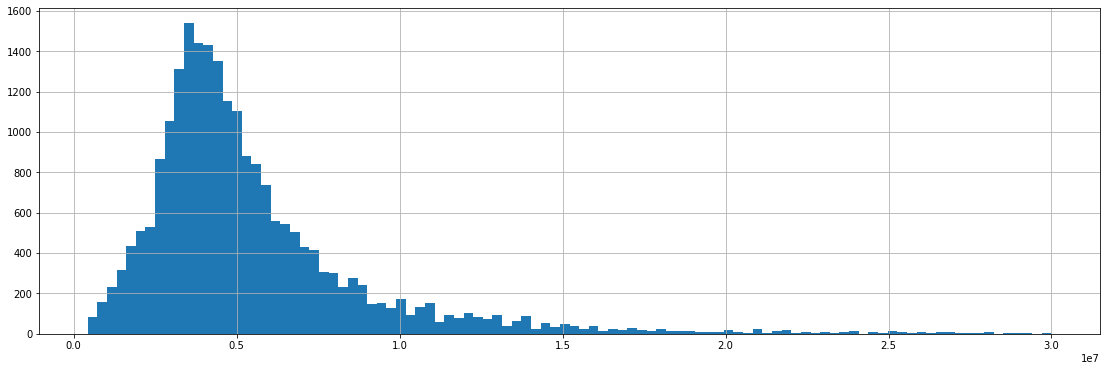

In [74]:
filtered_df['last_price'].hist(bins=100, figsize=(19,6));

Цена квартиры распределена в диапазоне 1 000 000 - 30 000 000 рублей с пиком в цены в районе 3 000 000

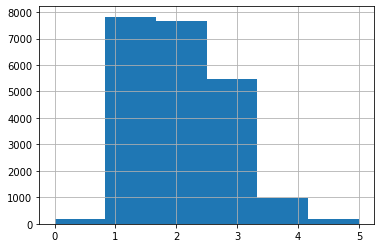

In [75]:
filtered_df['rooms'].hist(bins=6);

Колличество комнат распределено в диапазоне 0 - 7 комнат большая часть которых 2-3 комнатные, меньше всего 1 и 6-7 комнатных квартир

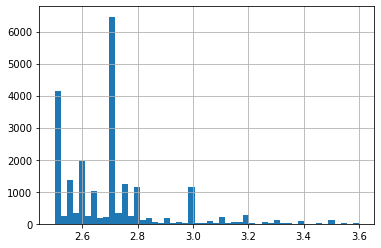

In [76]:
filtered_df['ceiling_height'].hist(bins=50);

Высота потолков распределена в диапазоне 2.4-3.6 метров с пиком в 2.7 метра

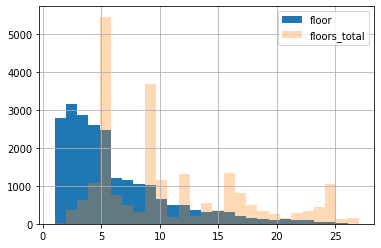

In [77]:
filtered_df['floor'].hist(bins=27, legend=True);
filtered_df['floors_total'].hist(bins=27, alpha=0.3, legend=True);

Этажи квартир распределены в диапазоне 10 - 27  этажей, большая часть квартир находится до 5го этажа, и больше всего домов с всего 5ю этажами, следующие по колличеству квартиры до 9го этажа и соответсвующе дома с всего 9ю этажами.

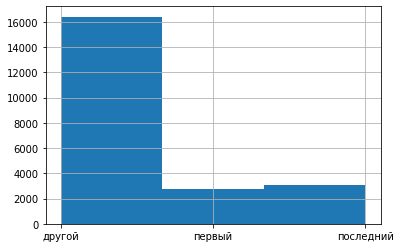

In [78]:
filtered_df['floor_type'].hist(bins=3);

Колличество квартир первых и последних этажей почти совпадает с превышением последних и находится в диапазоне 2600-3000, остальных квартир более 17000

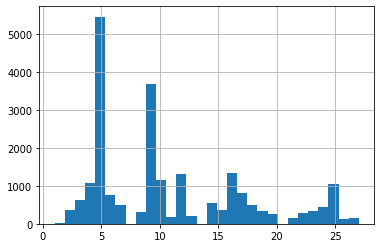

In [79]:
filtered_df['floors_total'].hist(bins=30);

Общее колличество этажей распределено в диапазоне 1-30 с пиком на 5 этажей и меньшим пиком в 9 этажей

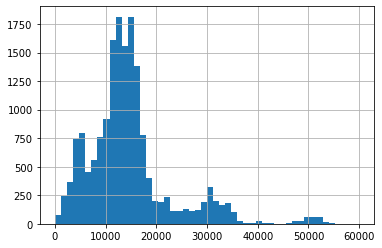

In [80]:
filtered_df['cityCenters_nearest'].hist(bins=50, range=(1, 60000));

Расстояние до центра в метрах расспределено в диапазоне 0-60000 с двумя пиками в 12000 и 14000 и меньшим пиком в 4000

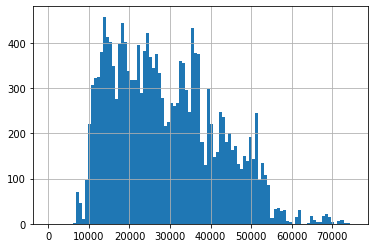

In [81]:
filtered_df['airports_nearest'].hist(bins=100, range=(1, 75000));

Расстояние до ближайшего аэропорта распределено в диапазоне 6000-75000 с пиками в 12000-18000 и меньшими пиками на 25000 и 36000

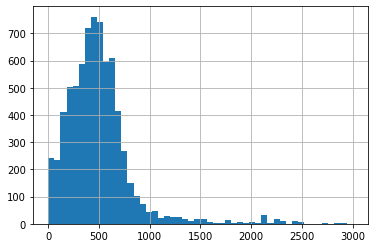

In [82]:
filtered_df['parks_nearest'].hist(bins=50, range=(1, 3000));

Расстояние до ближайшего парка распределено в диапазоне 0-3000 с пиком 480 метров

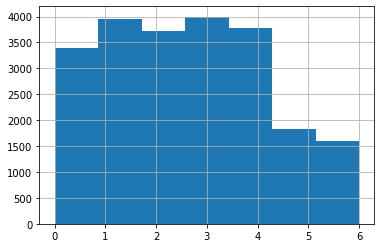

In [83]:
filtered_df['week_day_exposition'].hist(bins=7);

Чаще всего объявления публикуют среди рабочей недели, особенно во вторник и четверг. На выходных значительно реже

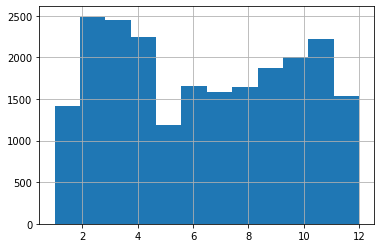

In [84]:
filtered_df['mounth_exposition'].hist(bins=12);

Чаще всего публикуют объявления в феврале, затем колличество публикаций уменьшается до минимальных значений в мае и снова начинает расти до ноября, затем следует спад в декабре-январе почти до синимальных значений

count    19366.000000
mean       174.438914
std        206.996901
min          3.000000
25%         44.000000
50%         93.000000
75%        224.000000
max       1240.000000
Name: days_exposition, dtype: float64

Не проданных квартир: 2921


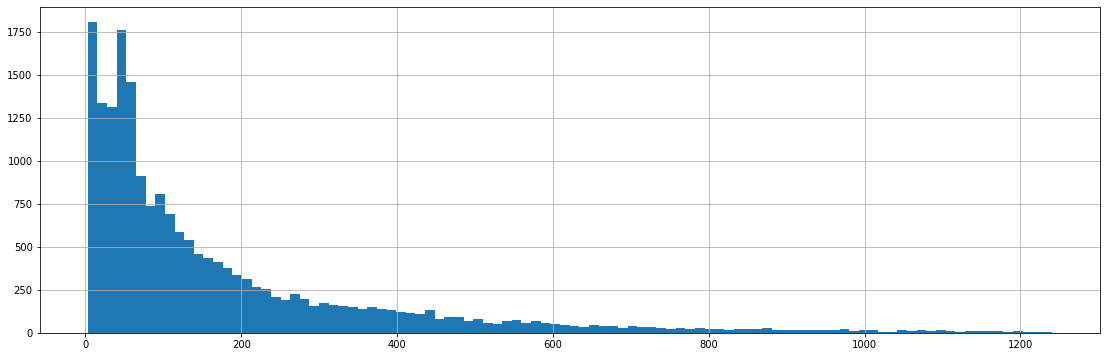

In [85]:
filtered_df['days_exposition'].hist(bins=100, figsize=(19, 6));
display(filtered_df['days_exposition'].describe())
print('Не проданных квартир:', filtered_df['days_exposition'].isna().sum())

Больше всего квартир продается в течении месяца, затем идет спад вплоть до 1240 дней. Среднее значение 174 дня, медиана 93 дня. Быстрой продажей будет считаться та, которая завершилась в первый квартиль(25 квантиль) до 44 дней, долгая же которая свыше третьего квартиля(75 квантиль) в 224 дня. Всего не проданныз квартир 2921.

<AxesSubplot:xlabel='year_exposition'>

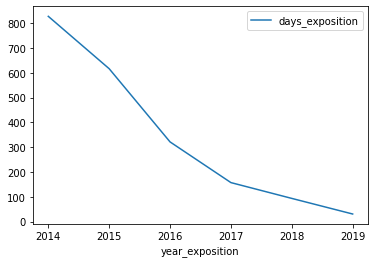

In [86]:
filtered_df.pivot_table(index='year_exposition', values='days_exposition').plot()

Cредняя скорость продаж в 2014 году превысила более 900 дней, а затем показатель начал снижаться до 700 в 2015 и 500 в 2016.

#### Определим зависимость цены от разных факторов

Построим график зависимости цены квартиры от её площади.

<AxesSubplot:xlabel='total_area'>

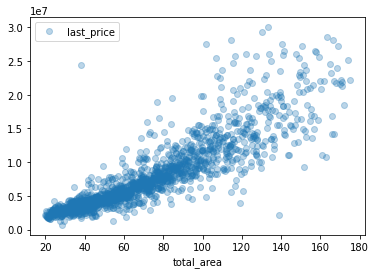

In [87]:
filtered_df.pivot_table(index='total_area', values='last_price').plot(style='o', alpha=0.3)

Зависямость прямо пропорциональная, хотя присутствуют выбросы от общей картины.

Построим график зависимости цены от жилой площади квартиры

<AxesSubplot:xlabel='living_area'>

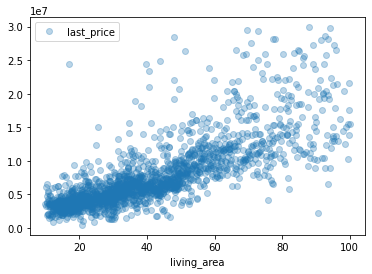

In [88]:
filtered_df.pivot_table(index='living_area', values='last_price').plot(style='o', alpha=0.3)

Зависимость прямо пропорциональная так же с незначительными выбросами значений.

Построим граик зависимости цены от площади кухни.

<AxesSubplot:xlabel='kitchen_area'>

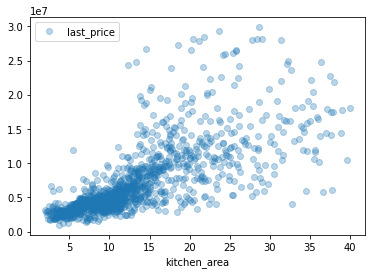

In [89]:
filtered_df.pivot_table(index='kitchen_area', values='last_price').plot(style='o', alpha=0.3)

Зависимость прямо пропорциональна, но не сталько сильно выраженная как на предыдущих графиках.

Построим граик зависимости цены от колличества комнат.

<AxesSubplot:xlabel='rooms'>

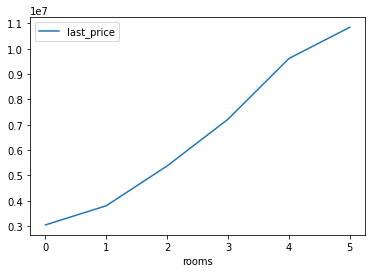

In [90]:
filtered_df.pivot_table(index='rooms', values='last_price').plot()

Зависимость явная и прямо пропорциональная

Построим граик зависимости цены от этажа.

<AxesSubplot:xlabel='floor'>

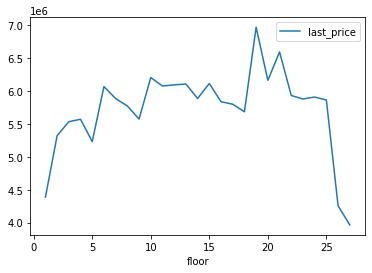

In [91]:
filtered_df.pivot_table(index='floor', values='last_price').plot()

Цена квартиры растет от первого до 10, затем чуть падает к 17. Пик цены для квартир с 20 этажом. Для более высоких этажей цена снова падает.

Зависимость цены от типа этажа.

<AxesSubplot:xlabel='floor_type'>

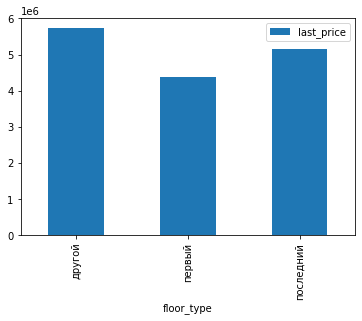

In [92]:
filtered_df.pivot_table(index='floor_type', values='last_price').plot(kind='bar')

Средняя цена первых и последних этажей меньше чем остальных и первые этажи оцениваются меьше всего.

Зависимость цены от дня недели публикации объявления.

<AxesSubplot:xlabel='week_day_exposition'>

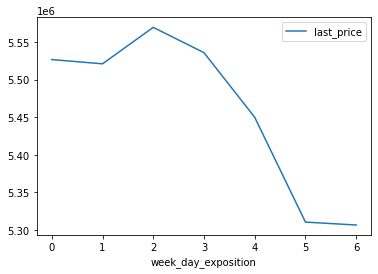

In [93]:
filtered_df.pivot_table(index='week_day_exposition', values='last_price').plot()

Объявления с большей ценой публикуют в середине недели, в среду-четверг. Объявления с меньшей ценой публикуют на выходных.

Зависимость цены от месяца публикации объявления.

<AxesSubplot:xlabel='mounth_exposition'>

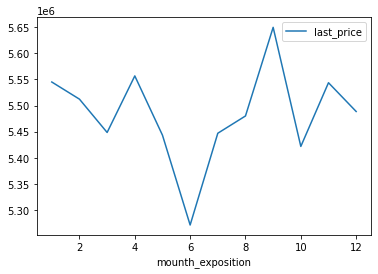

In [94]:
filtered_df.pivot_table(index='mounth_exposition', values='last_price').plot()

Объявления с самой высокой ценой публиковали в сентябре, а с самой меньшей в июне.

Зависимость цены от года публикации

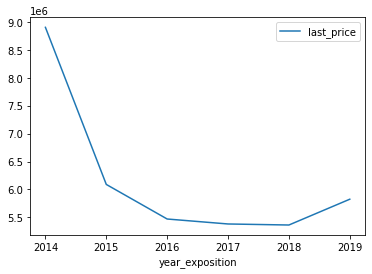

In [95]:
filtered_df.pivot_table(index='year_exposition', values='last_price').plot();

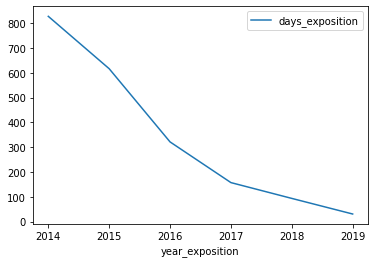

In [96]:
filtered_df.pivot_table(index='year_exposition', values='days_exposition').plot();

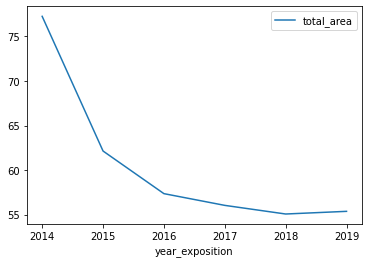

In [97]:
filtered_df.pivot_table(index='year_exposition', values='total_area').plot();

Цена квартир снижалась с 2014 г. вплоть до 2018 г. А в 2019 цена начала рости. Также снижалась с 2014 года и средняя площадь публикуемых квартир и общая стоимость. А средняя скорость продажи квартир наоборот росла с 2014 года. В 2019 году снова начала расти цена и площадь, а скорость продажи нет возможности оценить из-за недостаточного промежутка времени.

#### Посчитаем стоимость квадратного метра в 10 населенных пунктах с самым большим колличеством публикаций.

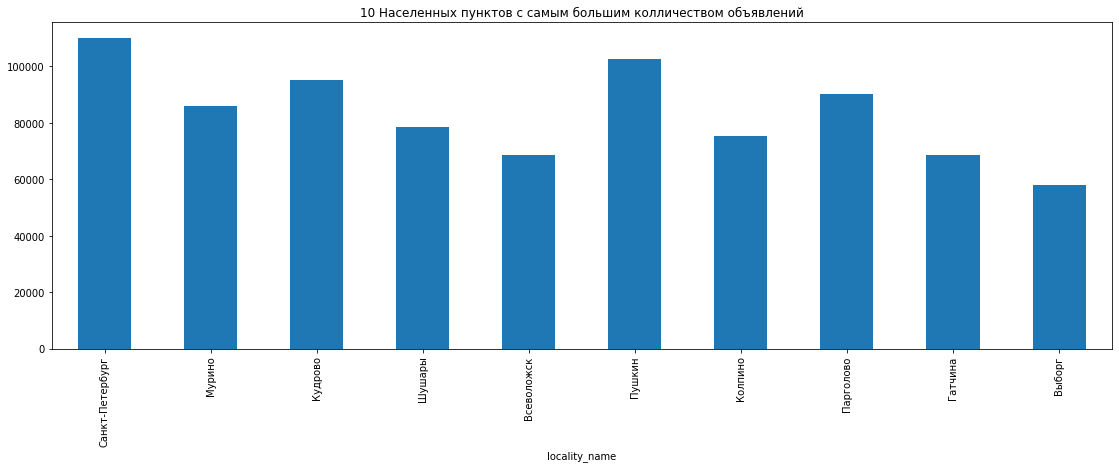

In [98]:
(
filtered_df.pivot_table(index='locality_name', values='metre_price', aggfunc=['mean', 'count'])
    .sort_values(by=('count', 'metre_price'), ascending=False).head(10)
    .plot(y=('mean', 'metre_price'), kind='bar', figsize=(19,6), legend=False, title='10 Населенных пунктов с самым большим колличеством объявлений')
    );

Самая большая цена на квадратный метр в Санкт-Петербурге.

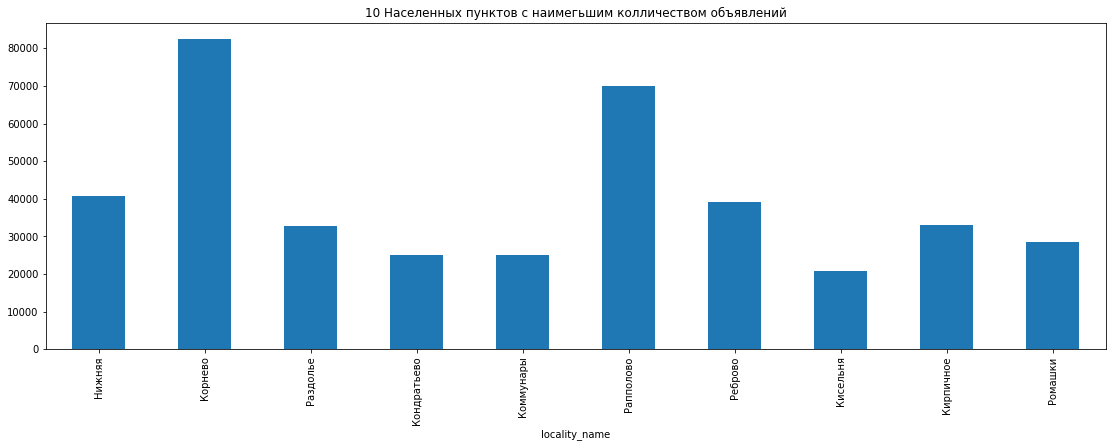

In [99]:
(
filtered_df.pivot_table(index='locality_name', values='metre_price', aggfunc=['mean', 'count'])
    .sort_values(by=('count', 'metre_price')).head(10)
    .plot(y=('mean', 'metre_price'), kind='bar', figsize=(19,6), legend=False, title='10 Населенных пунктов с наимегьшим колличеством объявлений')
    );

Самая низкая цена на квадратный метр В Старополье

In [100]:
# check
(
filtered_df.pivot_table(index='locality_name', values='metre_price', aggfunc=['mean', 'count'])
    .sort_values(by=('count', 'metre_price'), ascending=False).head(10))

,mean,count
,metre_price,metre_price
locality_name,,
Санкт-Петербург,110098.326462,14553
Мурино,85914.514834,573
Кудрово,95190.397408,463
Шушары,78527.795402,435
Всеволожск,68544.100257,389
Пушкин,102604.650289,346
Колпино,75408.555224,335
Парголово,90336.850794,315


#### Зависимость цены на квадратный метр по отношению к расстояюнию до центра в Санкт-Петербурге

Построим график зависимости цены от расстояния до центра

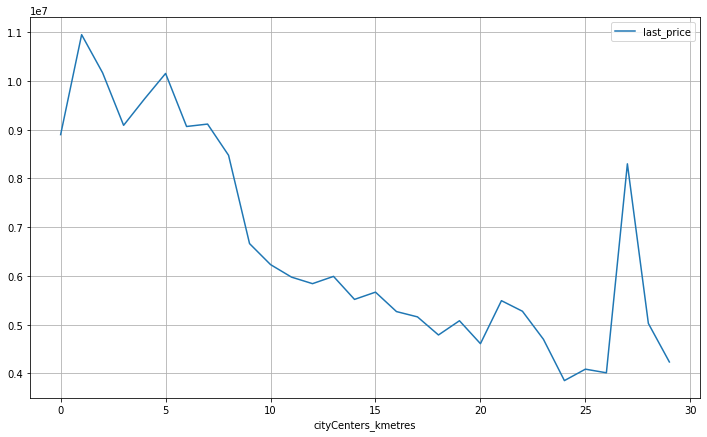

In [101]:
(
filtered_df.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_kmetres', values='last_price')
    .plot(grid=True, figsize=(12, 7))
    );

Зависимость цены квадратного метра от расстояния до центра обратно пропорциональна. График расположен практически линейно, следует изучить провалы на 0-1км, на 3 км и пик на 27км.

In [102]:
print('Колличество записей на нулевом километре', filtered_df['locality_name'][(
    filtered_df['locality_name'] == 'Санкт-Петербург') & (filtered_df['cityCenters_kmetres'] < 1)].count())
print('Колличество записей на третьем километре', filtered_df['locality_name'][(
    filtered_df['locality_name'] == 'Санкт-Петербург') & (filtered_df['cityCenters_kmetres'] == 3)].count())
print('Процент записей на третьем километре от всех', round(filtered_df['locality_name'][(
    filtered_df['locality_name'] == 'Санкт-Петербург') & (filtered_df['cityCenters_kmetres'] == 3)].count() /
      filtered_df['locality_name'][filtered_df['locality_name'] == 'Санкт-Петербург'].count()*100, 3)
     )
print('Колличество записей на двадцать седьмом километре', filtered_df['locality_name'][(
    filtered_df['locality_name'] == 'Санкт-Петербург') & (filtered_df['cityCenters_kmetres'] == 27)].count())



Колличество записей на нулевом километре 8
Колличество записей на третьем километре 285
Процент записей на третьем километре от всех 1.958
Колличество записей на двадцать седьмом километре 2


На данных участках сконцентрированн слишком малый процент записей, что бы можно было достоверно утверждать что это выбросы, из-за недостаточного колличества данных.

In [103]:
(
    filtered_df[filtered_df['locality_name'] == 'Санкт-Петербург']
     .query('3 <= cityCenters_kmetres <=5 ')
     .groupby(['cityCenters_kmetres', 'floor_type'])['last_price']
     .agg(['count', 'mean'])
     .style.format("{:,.0f}")
)

#### Построим диаграмму корреляций

In [104]:
filtered_df.loc[:, ['last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition']].corr()

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
last_price,1.000000,0.764929,0.459298,0.439382,0.113852,0.646943,0.095788,0.013506,-0.049742,-0.034192,0.600675,0.047575,0.271262,0.017229,0.277459,0.244363,0.298742,0.180662,0.109209
total_area,0.764929,1.000000,0.787539,0.375244,-0.026834,0.924766,-0.016376,0.018115,-0.094124,-0.056559,0.579850,0.048523,0.104764,-0.040690,0.153779,0.123300,0.174635,0.090268,0.142804
rooms,0.459298,0.787539,1.000000,0.154966,-0.219802,0.871784,-0.160283,-0.004417,-0.156186,-0.093599,0.206089,0.001511,0.038325,-0.027536,0.103782,0.062847,0.080820,0.042496,0.104499
ceiling_height,0.439382,0.375244,0.154966,1.000000,-0.034921,0.304091,-0.017286,0.045817,0.011346,0.006450,0.353453,-0.051355,0.020610,-0.159281,0.213505,0.134082,0.218275,0.083237,0.089940
floors_total,0.113852,-0.026834,-0.219802,-0.034921,1.000000,-0.151656,0.675157,-0.021533,0.069936,0.044513,0.226608,0.169741,0.170661,0.082476,-0.142315,-0.053109,-0.045607,0.027863,-0.046945
living_area,0.646943,0.924766,0.871784,0.304091,-0.151656,1.000000,-0.106634,0.013315,-0.067326,-0.039932,0.328367,0.020780,0.073640,-0.041091,0.154859,0.104437,0.145192,0.076655,0.130833
floor,0.095788,-0.016376,-0.160283,-0.017286,0.675157,-0.106634,1.000000,-0.011507,0.041336,0.030981,0.158578,0.167913,0.112055,0.053432,-0.096209,-0.033573,-0.028799,0.020191,-0.038001
is_apartment,0.013506,0.018115,-0.004417,0.045817,-0.021533,0.013315,-0.011507,1.000000,-0.003069,-0.002037,0.028934,0.033308,0.019633,0.022380,0.000209,-0.015987,0.007729,0.015257,-0.004138
studio,-0.049742,-0.094124,-0.156186,0.011346,0.069936,-0.067326,0.041336,-0.003069,1.000000,-0.003864,-0.091793,0.031558,-0.031840,-0.022377,-0.033588,-0.023500,-0.013820,-0.010536,-0.015603
open_plan,-0.034192,-0.056559,-0.093599,0.006450,0.044513,-0.039932,0.030981,-0.002037,-0.003864,1.000000,-0.053567,0.034350,-0.027005,-0.020660,-0.017437,-0.011819,-0.011226,-0.003675,-0.022265


Из диаграммы видно что цена last_price корелирует с общими показателями квартиры(колличество комнать, площади общая, жилая, кухни и высота потолков). Есть небольшая положительная корреляция с положением относительно аэропорта, парков и прудов, но при этом почти нет относительно центра. Этаж и общее колличество этажей, а также балконы имеют околонулевую кореляцию. Апартаменты, студия, свободная планоривка так же не имеют корреляции.

### Общий вывод

Нами было проведено исследование по определению зависимости цены квартиры в Санкт-Петербурге и области. Для анализа были взяты  23699 объявлений о продаже квартиры за 2014-2019 года. Результатом исследования будет являться выявление факторов влияющих на стоимость квартиры и статистика о продажах во временном срезе.

Во время исследования нами были проанализированны следующиее данные: площади квартиры(общая, жилая и кухни), колличество комнат, этаж и общее колличество этажей, высота потолков и расстояния до различных объектов(до центра города, аэропорта, парка и пруда). 

Нами были выявленны стедующие зависимости:

#### Цена квартиры прямо пропорционально зависит от её площади

Зависимость цены прямо пропорциональна площади квартиры и растет линейно. 

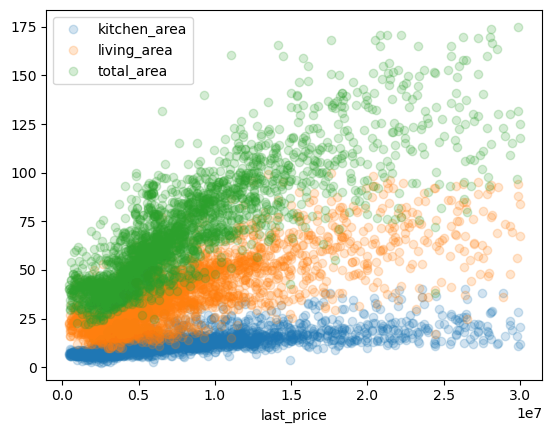

#### Цена квартиры зависит от колличества комнат

Зависимость прямо пропорциональная и линейная.

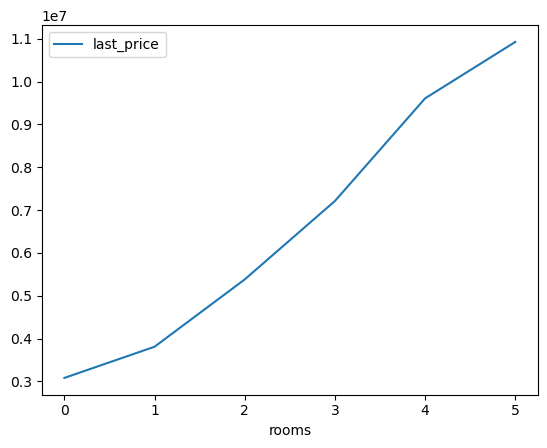

#### Цена квартины зависит от этажа

Видна зависимость от типа этажа, первый и последний этаж дешевле чем остальные, и первый дешевле чем последний. По колличеству домов больше всего 5ти и 9ти этажных.

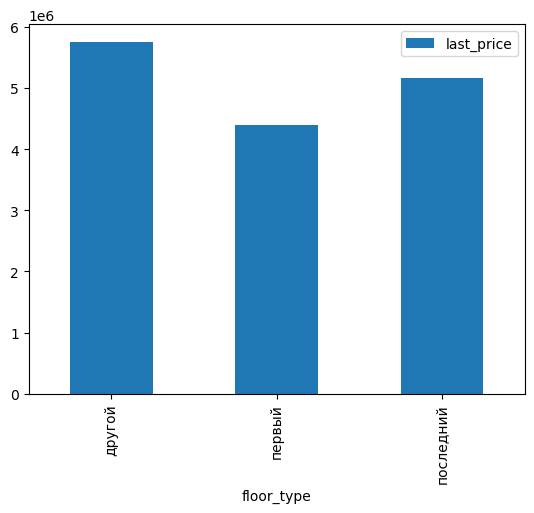



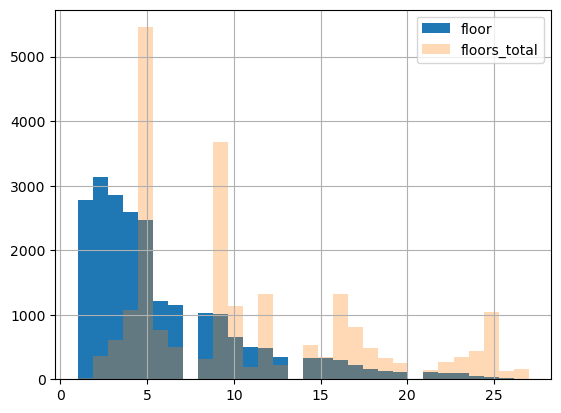

Цена квартиры растет до 19 этажа, а затем падает.  На графике есть провалы на 5, 9, на этих значениях сконцентрированна большая часть домов где квартира на последнем этаже, так что прослеживается связь с типом этажа.

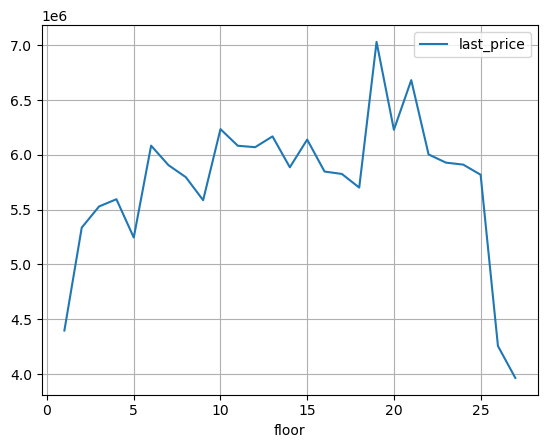

#### Зависимость от времени размещения объявления

Квартиры с более высокой стоимостью публикуются в середине недели, а с низкой на выходных. 

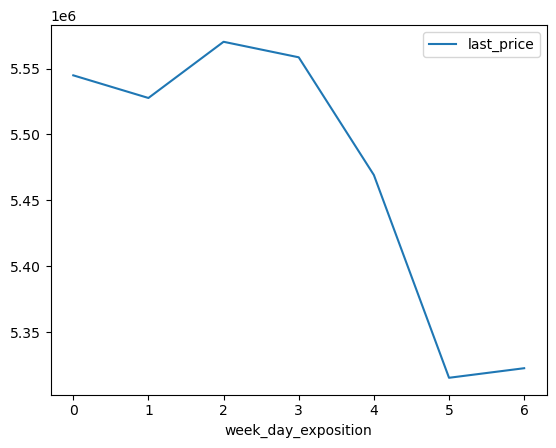


Квартиры с более высокой стоимостю публикуются в начале осени, начале зимы и начале весны, к концу сезона идет спад, а летом наоборот, самые низкие цены и к концу сезона происходит рост цен. 

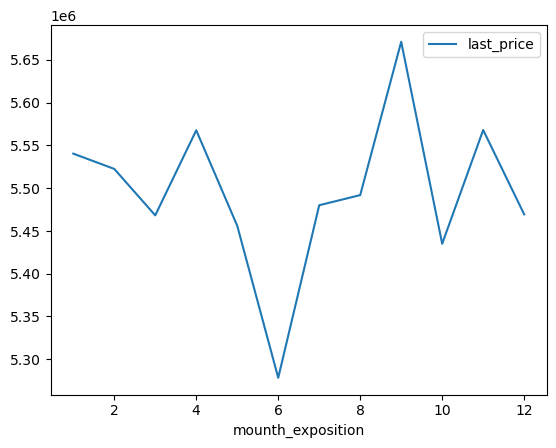


В 2014 в выборке наблюдаются самые высокие цены на квартиры и до 2018 года цена падала, в 2019 году цена на квартиры начала расти

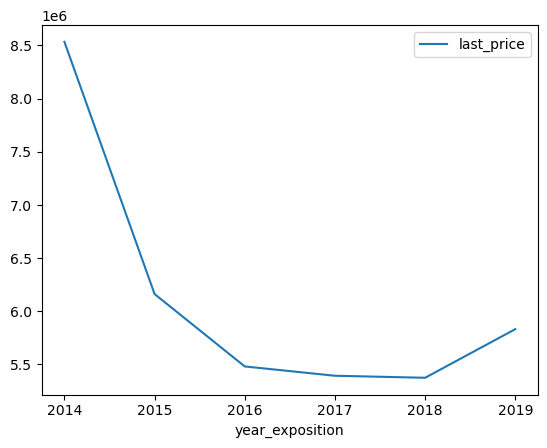

#### Цена квартиры зависит от удаления от центра города

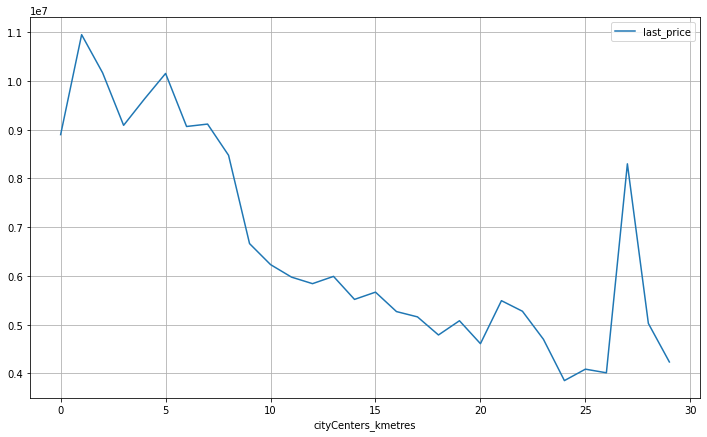

Цена линейно падает от удаления от центра. Провалы на нулевом, третьем и пик на двадцать седьмом километре объясняются небольшим колличеством записей на данных расстояниях

#### Цена квартиры зависит от населенного пункта, где она расположенна

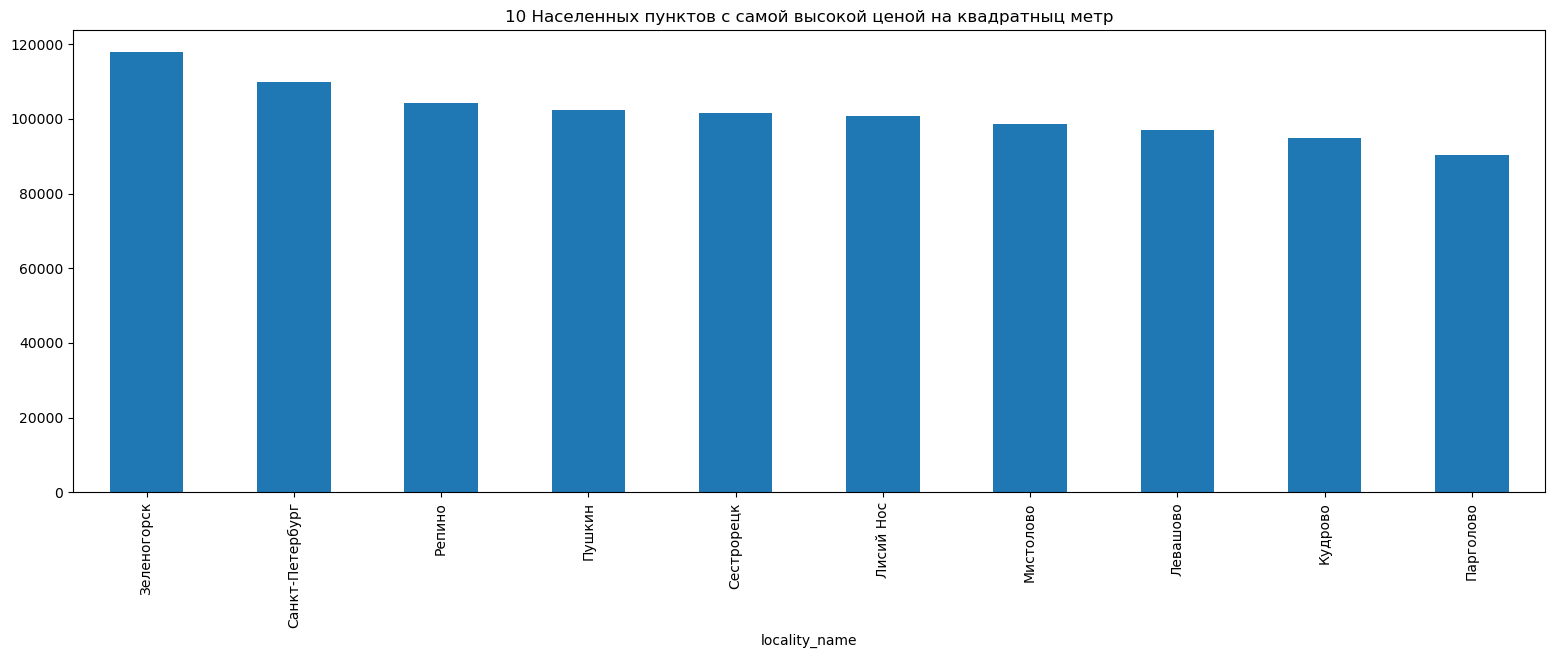

Цена на квадратный метр больше всего в Зеленогорске и Санкт-Петарбурге, 115000 и 110500 соответственно.

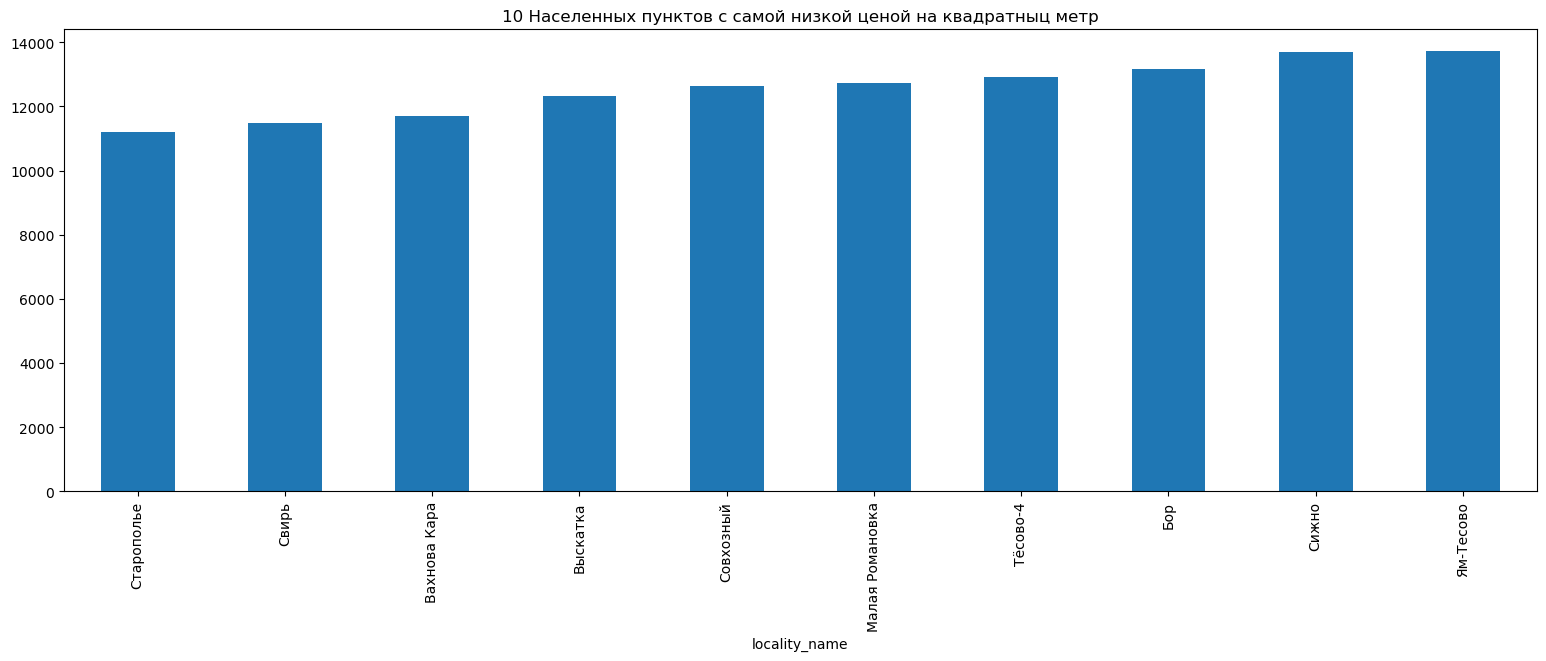

Самая низкая цена в Ставрополье, в 10 раз дешевле чем в Зеленогорске, 11200 соответственно.

#### Корреляция цены

Цена коррелирует с общими показателями квартиры(колличество комнат, высота потолков, площади: общая, жилая, кухни). Есть небольшая положительная корреляция с положением относительно аэропорта, парков и прудов, но при этом относительно центра небольшая отрицательная корреляция. Этаж и общее колличество этажей, а также балконы имеют околонулевую кореляцию. Апартаменты, студия, свободная планоривка так же не имеют корреляции.

In [105]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

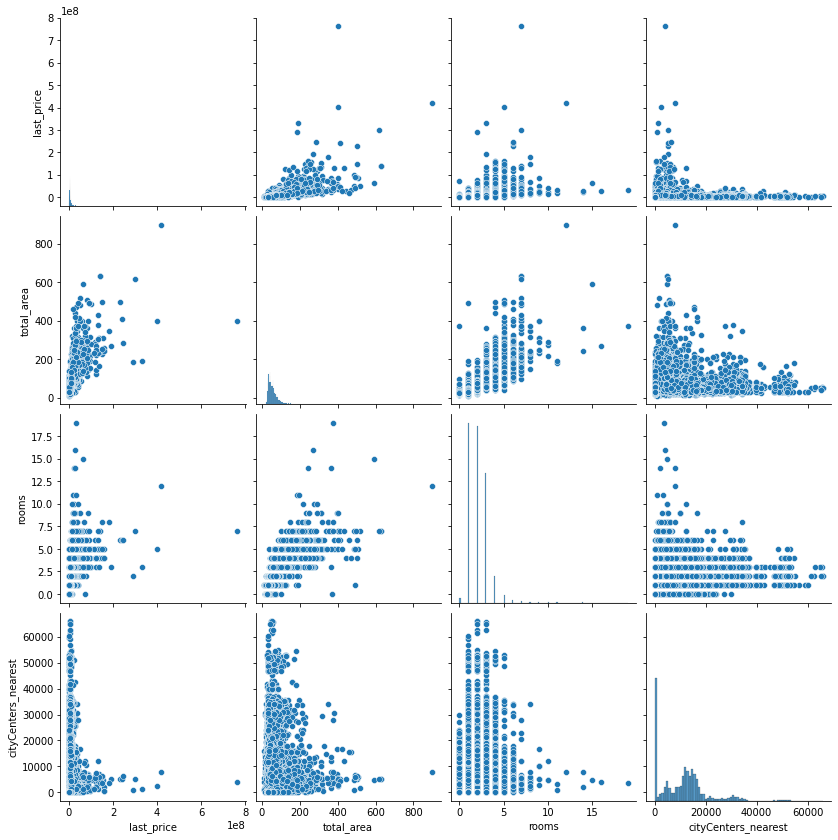

In [106]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


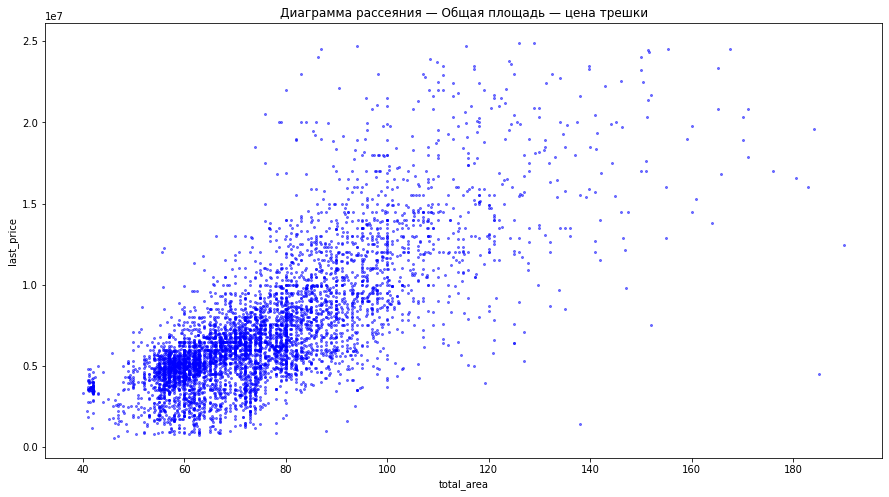

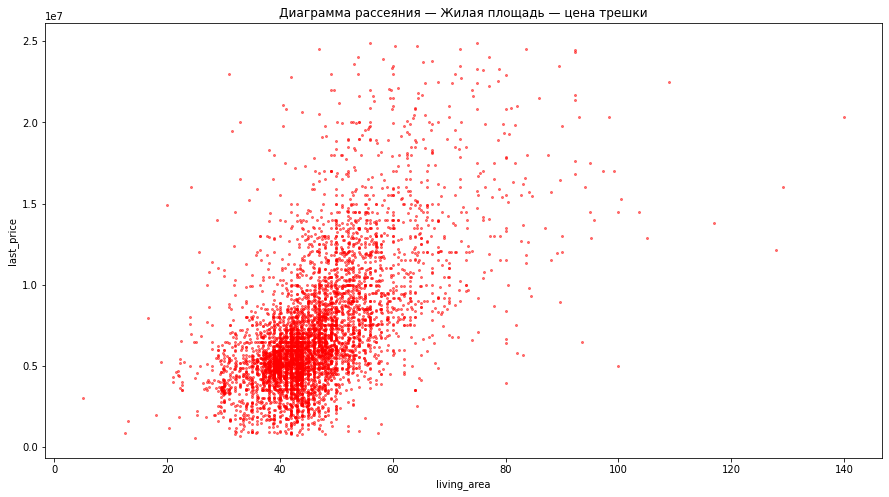

In [107]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

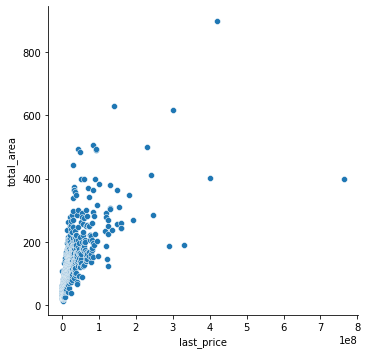

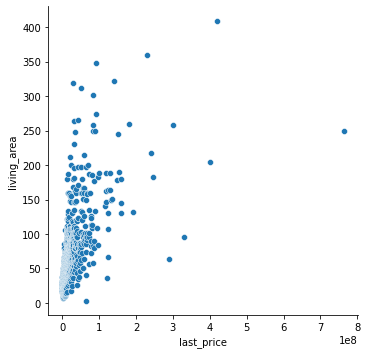

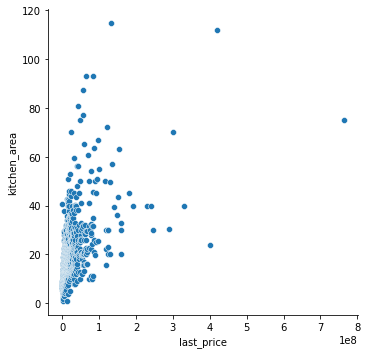

In [108]:
# check
price_pivot_area = data.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area = price_pivot_area.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area, x='last_price', y=row, kind='scatter')